# Timeseries Data Analysis - Dexamethasone GR

This Jupyter notebook contains a series of Dexamethasone timeseries datasets from ENCODE. These data include EP300 ChIP-Seq, H3K27ac ChIP-Seq, DNAse-Seq, ATAC-Seq and other data in A549 cells.

# Table of Contents
1. [Initialize](#Initialize)<br>
2. [Run TFEA](#Run-TFEA)<br>
3. [Run AME](#Run-AME)<br>
4. [Main Figure](#Main-Figure)<br>
    4.1 [Dexamethasone Timeseries TFEA Analysis](#Dexamethasone-Timeseries-TFEA-Analysis)<br>
5. [Supplemental Figures](#Supplemental-Figures)<br>
    5.1 [TFEA Extended Results](#TFEA-Extended-Results)<br>
    5.2 [AME Dex Tiemseries](#AME-Dex-Tiemseries)<br>
    5.3 [MD-Score Dex Timeseries](#MD-Score-Dex-Timeseries)<br>
    5.3 [MDD-Score Dex Timeseries](#MDD-Score-Dex-Timeseries)<br>
6. [Additional Analysis](#Additional-Analysis)<br>
    6.1 [TFEA run on TF ChIP data](#TFEA-run-on-TF-ChIP-data)<br>
    6.2 [DE-Seq MA plot of GR ChIP Peaks](#DE-Seq-MA-plot-of-GR-ChIP-Peaks)<br>
    6.3 [GR Enrichment Profile](#GR-Enrichment-Profile)<br>
    6.4 [AME run on TF ChIP data](#AME-run-on-TF-ChIP-data)<br>

## Initialize

In [2]:
#User Inputs
output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/TFEA/'
motif_database = '/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme'
figuredir = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/Figures/'

#Imports
#==================================================================================================
#Add user installed python packages and TFEA
import sys
sys.path.insert(0, "/Users/joru1876/.local/lib/python3.6/site-packages/")
sys.path.insert(0, "/Users/joru1876/TFEA/")
# sys.path.insert(0, "/scratch/Users/joru1876/TFEA/TFEA/")

#Add MEME and Sbatch to path
import os
os.environ['PATH'] = '/Users/joru1876/meme/bin:' + os.environ['PATH'] + ':/opt/slurm-19.05.2/bin/:/Users/joru1876/TFEA/TFEA'

import time
import math
from scipy import stats
import numpy as np
from pathlib import Path
import subprocess
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from IPython.display import FileLink
import pypdftk

import TFEA

#Organize timeseries comparisons
#============================================================
data = Path('/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse2/processed_data/')

beds = {}
for bedfile in data.glob('*.bed'):
    condition_list = bedfile.stem.split('_')
    if len(condition_list) == 4:
        assay, treatment, _, rep = bedfile.stem.split('_')
#         if 'min' in treatment:
#             treatment = 'dex' + str(float(treatment.strip('dex').strip('min'))/60.0) + 'hr'
        if assay not in beds:
            beds[assay] = {}
        if treatment not in beds[assay]:
            beds[assay][treatment] = []

        beds[assay][treatment].append(str(bedfile))
    

bams = {}
for bamfile in data.glob('*.bam'):
    condition_list = bamfile.stem.split('_')
    if len(condition_list) == 4:
        assay, treatment, _, rep = bamfile.stem.split('_')
#         if 'min' in treatment:
#             treatment = 'dex' + str(float(treatment.strip('dex').strip('min'))/60.0) + 'hr'
        if assay not in bams:
            bams[assay] = {}
        if treatment not in bams[assay]:
            bams[assay][treatment] = []

        bams[assay][treatment].append(str(bamfile))

#Functions
#=======================================================================================================
def parse_results(parent_folder, beds=None, results_file=None, assay=None, ame=False):
    '''
    Parameters
    ----------
    parent_folder : full path to a folder containing TFEA folders
    beds : dict of dicts with key1 = assay (ATAC, H3K27ac); key2 = treatment time (dex0hr); value = file
    results_file : str : name of tsv file to look for (results.txt, md_results.txt, mdd_results.txt)
    '''
    results = dict()
    for treatment in beds[assay]:
        if treatment != 'dex0hr':
            results[treatment] = list()
            if ame:
                result_file = Path(parent_folder) / (assay + '_dex0hr_' + treatment) / 'ame' / results_file
            else:
                result_file = Path(parent_folder) / (assay + '_dex0hr_' + treatment) / results_file
            result_list = [line.split('\t') for line in result_file.read_text().split('\n') if len(line.split('\t')) != 0 and '#' not in line.split('\t')[0]]
            result_list = [[line[0]] + [float(x) for x in line[1:]] for line in result_list]
            results[treatment].append(result_list)
    
    return results

def plot_H3K27ac_time_results(results, motif=None, ax=None, x_index=2):                
    sorted_keys = sorted([int(x.strip('dex').strip('min')) for x in results.keys()])
    sorted_keys = ['dex' + str(x) + 'min' for x in sorted_keys]
    xvals = [i for i in range(len(sorted_keys))]
    
    all_results = [[[x2[x_index] for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
    all_results = np.array(all_results).T
    for motif_per_timepoint in all_results:
        ax.plot(xvals, motif_per_timepoint, c='b', alpha=0.5)
    ax.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, alpha=0.5)
    
    if motif != None:
        motif_results = [[[x2[x_index] for x2 in x if x2[0] == motif] for x in results[key]][0] for key in sorted_keys]
        ax.plot(xvals, motif_results, c='r')
        ax.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, c='r')
    
    plt.xticks(xvals, sorted_keys)
    
def flatten(pdf_file):
    pdf_file = str(pdf_file)
    output = pdf_file.replace('.pdf', '_flat.pdf')
    subprocess.call('/usr/bin/pdf2ps ' + pdf_file + ' - | /usr/bin/ps2pdf - ' + output, shell=True)
    return output

## Run TFEA

In [4]:
TFEA_executable = '/Users/joru1876/TFEA/TFEA'
config = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse2/TFEA/TFEA_config.ini'
output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse2/TFEA/'
for assay in beds:
    for treatment in beds[assay]:
        if treatment != 'dex0hr':
            bed1 = beds[assay]['dex0hr']
            bed2 = beds[assay][treatment]
            bam1 = bams[assay]['dex0hr']
            bam2 = bams[assay][treatment]
            TFEA_command = ['python3', TFEA_executable,
                            '--bed1', ' '.join(bed1),
                            '--bed2', ' '.join(bed2),
                            '--bam1', ' '.join(bam1),
                            '--bam2', ' '.join(bam2),
                            '--label1', 'dex0hr',
                            '--label2', treatment,
                            '--config', config,
                            '--md', '--mdd',
                            '--sbatch', 'joru1876@colorado.edu', 
                            '--debug',
                            '--fimo_thresh', '0.000001',
                            '--enrichment', 'auc',
                            '--output', Path(output_folder) / (assay + '_dex0hr_' + treatment),
                            '--cpus', '10']
            try:
                subprocess.run(TFEA_command, 
                                stderr=subprocess.PIPE, 
                                stdout=subprocess.PIPE,
                                check=True)
            except subprocess.CalledProcessError as e:
                print(e.stderr.decode())
            print('Submitted: ' + assay + '_dex0hr_' + treatment)
            time.sleep(2)

Submitted: H3K4me1_dex0hr_dex30min
Submitted: H3K4me1_dex0hr_dex7hr
Submitted: H3K4me1_dex0hr_dex3hr
Submitted: H3K4me1_dex0hr_dex1hr
Submitted: H3K4me1_dex0hr_dex10hr
Submitted: H3K4me1_dex0hr_dex12hr
Submitted: H3K4me1_dex0hr_dex2hr
Submitted: H3K4me1_dex0hr_dex6hr
Submitted: H3K4me1_dex0hr_dex8hr
Submitted: H3K4me1_dex0hr_dex5hr
Submitted: H3K4me1_dex0hr_dex4hr
Submitted: EP300_dex0hr_dex1hr
Submitted: EP300_dex0hr_dex10hr
Submitted: EP300_dex0hr_dex7hr
Submitted: EP300_dex0hr_dex20min
Submitted: EP300_dex0hr_dex5hr
Submitted: EP300_dex0hr_dex25min
Submitted: EP300_dex0hr_dex30min
Submitted: EP300_dex0hr_dex6hr
Submitted: EP300_dex0hr_dex5min
Submitted: EP300_dex0hr_dex8hr
Submitted: EP300_dex0hr_dex10min
Submitted: EP300_dex0hr_dex12hr
Submitted: EP300_dex0hr_dex3hr
Submitted: EP300_dex0hr_dex2hr
Submitted: EP300_dex0hr_dex15min
Submitted: EP300_dex0hr_dex4hr
Submitted: ATAC_dex0hr_dex4hr
Submitted: ATAC_dex0hr_dex8hr
Submitted: ATAC_dex0hr_dex1hr
Submitted: ATAC_dex0hr_dex12hr
Sub

## Run AME

Note: Uses background files generated by TFEA so you need to wait for those jobs to complete before running AME

In [14]:
fasta_directory = Path(output_folder)
fasta_directory = Path('/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse2/TFEA/')

pattern = '*/temp_files/ranked_file.fa'

for F in fasta_directory.glob(pattern):
    TFEA_directory = F.parent.parent
    print(TFEA_directory.name)
    e_and_o = TFEA_directory / 'e_and_o'
    ame_output = TFEA_directory / 'ame'
    background = TFEA_directory / 'temp_files' / 'markov_background.txt'
    ame_sbatch = TFEA_directory / 'ame.sbatch'
    ame_sbatch.write_text('''#!/bin/bash

###Name the job
#SBATCH --job-name=AME

###Specify the queue
#SBATCH -p long

###Specify WallTime
#SBATCH --time=100:00:00

### Specify the number of nodes/cores
#SBATCH --ntasks=1

### Allocate the amount of memory needed
#SBATCH --mem=5gb

### Setting to mail when the job is complete
#SBATCH --error /Users/joru1876/e_and_o/%x.err
#SBATCH --output /Users/joru1876/e_and_o/%x.out

### Set your email address
#SBATCH --mail-type=ALL
#SBATCH --mail-user=jonathan.rubin@colorado.edu

### Load required modules
module purge
module load python/3.6.3
module load bedtools/2.25.0
module load python/3.6.3/matplotlib/1.5.1
module load python/3.6.3/scipy/0.17.1
module load python/3.6.3/numpy/1.14.1
module load meme/5.0.3

### now call your program
/Users/joru1876/meme-5.0.5/src/ame --noseq --evalue-report-threshold 1000 --oc $output --bfile $bfile $fasta $motif_file''')
        
    ame_submit_command = ['sbatch', '--job-name=AME_' + F.name, 
                          '--export=output=' + str(ame_output) + ',bfile=' + str(background) + ',fasta=' + str(F) + ',motif_file=' + motif_database, 
                          '--error=' + str(e_and_o / "%x.err"), 
                          '--output=' + str(e_and_o / "%x.out"), 
                          ame_sbatch]
    try:
        subprocess.run(ame_submit_command, 
                        stderr=subprocess.PIPE, 
                        stdout=subprocess.PIPE,
                        check=True)
    except subprocess.CalledProcessError as e:
        print(e.stderr.decode())
    time.sleep(20)

EP300_dex0hr_dex25min
NR3C1_dex0hr_dex20min
EP300_dex0hr_dex4hr
NR3C1_dex0hr_dex8hr
JUN_dex0hr_dex3hr
JUN_dex0hr_dex10min
NR3C1_dex0hr_dex2hr
NR3C1_dex0hr_dex3hr
JUN_dex0hr_dex8hr
EP300_dex0hr_dex10hr
JUN_dex0hr_dex2hr
EP300_dex0hr_dex30min
EP300_dex0hr_dex5hr
EP300_dex0hr_dex7hr
EP300_dex0hr_dex12hr
JUN_dex0hr_dex5min
NR3C1_dex0hr_dex30min
NR3C1_dex0hr_dex1hr
NR3C1_dex0hr_dex25min
EP300_dex0hr_dex20min
JUN_dex0hr_dex1hr
NR3C1_dex0hr_dex5min
JUN_dex0hr_dex15min
EP300_dex0hr_dex6hr
EP300_dex0hr_dex2hr
EP300_dex0hr_dex10min
NR3C1_dex0hr_dex15min
JUN_dex0hr_dex5hr
NR3C1_dex0hr_dex10hr
EP300_dex0hr_dex8hr
NR3C1_dex0hr_dex4hr
JUN_dex0hr_dex25min
NR3C1_dex0hr_dex5hr
JUN_dex0hr_dex30min
JUN_dex0hr_dex4hr
JUN_dex0hr_dex10hr
EP300_dex0hr_dex3hr
EP300_dex0hr_dex1hr
JUN_dex0hr_dex12hr
EP300_dex0hr_dex5min
JUN_dex0hr_dex6hr
NR3C1_dex0hr_dex7hr
NR3C1_dex0hr_dex6hr
NR3C1_dex0hr_dex10min
EP300_dex0hr_dex15min
NR3C1_dex0hr_dex12hr
JUN_dex0hr_dex7hr
JUN_dex0hr_dex20min


# Main Figure

## Dexamethasone Timeseries TFEA Analysis

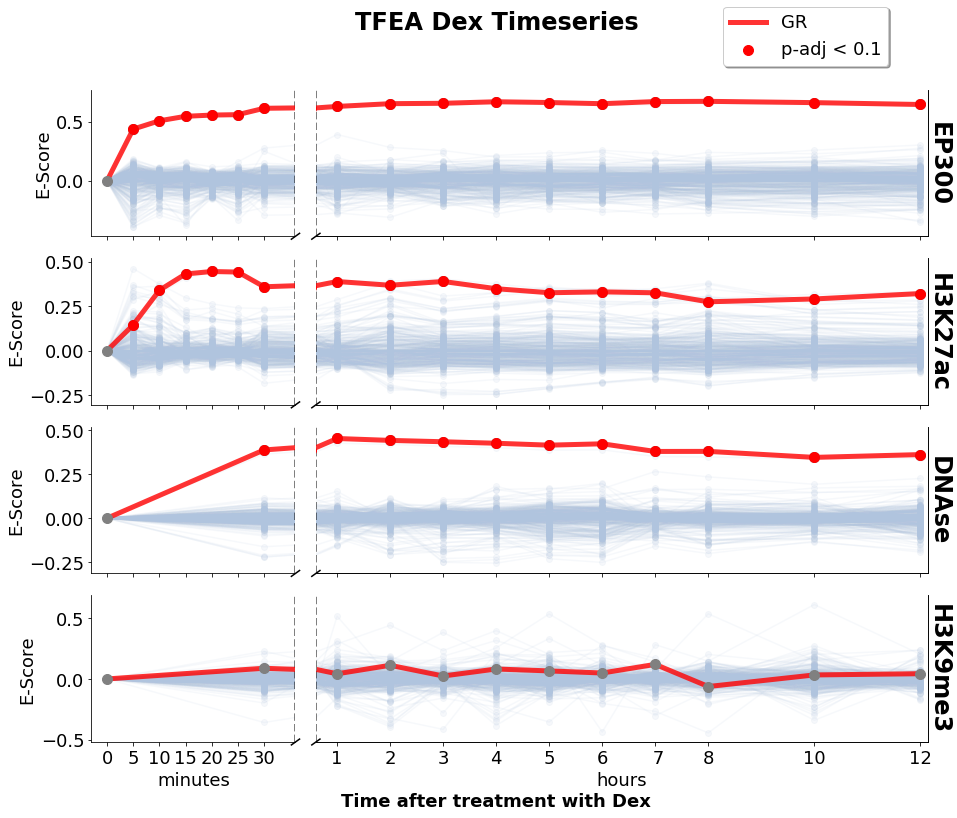

/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/Figures/TFEA_Dex_timeseries_Main_mumerge_flat.pdf

In [5]:
def parse_results(parent_folder, results_file=None, assay=None, ame=False):
    '''
    Parameters
    ----------
    parent_folder : full path to a folder containing TFEA folders
    beds : dict of dicts with key1 = assay (ATAC, H3K27ac); key2 = treatment time (dex0hr); value = file
    results_file : str : name of tsv file to look for (results.txt, md_results.txt, mdd_results.txt)
    '''
    results = dict()
    for folder in Path(parent_folder).glob('*'):
        info = folder.name.split('_')
        exp = info[0]
        treatment = ''.join(info[1:]).replace('dex0hr', '').replace('hour', 'hr').replace('minute', 'min')
        treatment = 'dex' + treatment if 'dex' not in treatment else treatment
        if exp == assay:
            results[treatment] = list()
            if ame:
                result_file = folder / 'ame' / results_file
            else:
                result_file = folder / results_file
            if ame:
                result_list = [line.split('\t') for line in result_file.read_text().split('\n')[1:] if len(line.split('\t')) > 1 and '#' not in line.split('\t')[0]]
                result_list = [[line[2]] + [x for x in line[5:]] for line in result_list]
            else:
                result_list = [line.split('\t') for line in result_file.read_text().split('\n')[:-1] if '#' not in line[0]]
                result_list = [[line[0]] + [float(x) for x in line[1:-1]] for line in result_list]
            results[treatment].append(result_list)
    return results

def plot_time_results(results, motif=None, outer=None, x_index=2, ame=False, motif_i=0, events_i=3,label='', 
                      ticks=False, p_cut=1e-1, p_i=-1):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer, wspace=0.05, width_ratios=[1,3])
    ax_l = plt.Subplot(F, inner[0])
    ax_r = plt.Subplot(F, inner[1])
    
    sorted_keys = sorted([float(x.strip('dex').strip('min'))/60.0 if 'min' in x else float(x.strip('dex').strip('hr')) for x in results.keys()])
    xvals = [0] + sorted_keys
    sorted_keys = ['dex' + str(int(x)) + 'hr' if x.is_integer() else 'dex' + str(int(x*60.0)) + 'min' for x in sorted_keys]
    
    if ame:
        all_results = [[[-math.log(float(x2[x_index]),10) if 'e' not in x2[x_index] else float(x2[x_index].split('e')[-1].strip('-')) for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
    else:
        all_results = [[0 for x2 in x] for x in results[sorted_keys[0]]] + [[[x2[x_index] for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
        
    ax_l.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, c='lightsteelblue', alpha=0.1, zorder=1)
    ax_r.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, c='lightsteelblue', alpha=0.1, zorder=1)
    all_results = np.array(all_results).T
    for motif_per_timepoint in all_results:
        ax_l.plot(xvals, motif_per_timepoint, c='lightsteelblue', alpha=0.1, zorder=2)
        ax_r.plot(xvals, motif_per_timepoint, c='lightsteelblue', alpha=0.1, zorder=2)

    if motif != None:
        list_flatten = lambda l: [item for sublist in l for item in sublist]
        if ame:
            motif_results = [[[-math.log(float(x2[x_index]),10) if 'e' not in x2[x_index] else float(x2[x_index].split('e')[-1].strip('-')) for x2 in x if x2[motif_i] == motif] for x in results[key]][0] for key in sorted_keys]
            significant_i = [[[k for x2 in x if x2[motif_i] == motif and float(x2[p_i]) < p_cut] for x in results[sorted_keys[k]]][0] for k in range(len(sorted_keys))]
            significant_i = list_flatten(significant_i)
        else:
            motif_results = [[0]] + [[[x2[x_index] for x2 in x if x2[motif_i] == motif] for x in results[key]][0] for key in sorted_keys]
            significant_i = [[[k+1 for x2 in x if x2[motif_i] == motif and x2[p_i] < p_cut] for x in results[sorted_keys[k]]][0] for k in range(len(sorted_keys))]
            significant_i = list_flatten(significant_i)
            
        ax_l.plot(xvals, motif_results, c='r', alpha=0.8, linewidth=5, label=motif, zorder=3)
        ax_l.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, color='gray', zorder=4)
        if len(significant_i) > 0:
            ax_l.scatter([xvals[i] for i in significant_i], [motif_results[i] for i in significant_i], s=100, color='red', zorder=5)
            ax_r.scatter([xvals[i] for i in significant_i], [motif_results[i] for i in significant_i], s=100, color='red', zorder=5)
        ax_r.plot(xvals, motif_results, c='r', alpha=0.8, linewidth=5, label='GR', zorder=3)
        ax_r.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, color='gray', zorder=4)
    if ticks:
        xticks = [0, 5/60, 10/60, 15/60, 20/60, 25/60, 30/60, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12]
        xlabels = ['0', '5', '10', '15', '20', '25', '30', '1','2', '3', '4', '5', '6',' 7', '8', '10', '12']
        ax_l.get_xaxis().set_ticks(xticks)
        ax_r.get_xaxis().set_ticks(xticks)
        ax_l.set_xticklabels(xlabels)
        ax_r.set_xticklabels(xlabels)
        ax_l.set_xlabel('minutes')
        ax_r.set_xlabel('hours')
    else:
        xticks = [0, 5/60, 10/60, 15/60, 20/60, 25/60, 30/60, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12]
        ax_l.get_xaxis().set_ticks(xticks)
        ax_r.get_xaxis().set_ticks(xticks)
        ax_l.set_xticklabels([])
        ax_r.set_xticklabels([])
    ax_l.set_xlim([-0.05, 0.6])
    ax_r.set_xlim([0.6, 12.15])
    ax_r.axvline(0.6, linestyle='--', c='k', linewidth=2, alpha=0.5)
    limits = [min(ax_l.get_ylim()[0], ax_r.get_ylim()[0]), max(ax_l.get_ylim()[1], ax_r.get_ylim()[1])]
    ax_l.set_ylim(limits)
    ax_r.set_ylim(limits)
    ax_l.axvline(0.6, linestyle='--', c='k', linewidth=2, alpha=0.5)
    
    F.add_subplot(ax_r)
    F.add_subplot(ax_l)
    ax_l.set_ylabel('E-Score')
    ax_r.spines['top'].set_visible(False)
    ax_l.spines['top'].set_visible(False)
    ax_l.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(False)
    ax_r.get_yaxis().set_ticks([])
    #Draw cuts in plot
    d=0.02
    kwargs = dict(transform=ax_l.transAxes, color='k', clip_on=False)
    ax_l.plot((1-d, 1+d), (-d, +d), **kwargs)
    kwargs.update(transform=ax_r.transAxes)
    ax_r.plot((-d/3.0, +d/3.0), (-d, +d), **kwargs)
    
    axR = ax_r.twinx()
    axR.set_ylabel(label, rotation=270, labelpad=22, fontweight='bold', fontsize=24)
    axR.axes.get_yaxis().set_ticks([])
    axR.spines['top'].set_visible(False)
    axR.spines['left'].set_visible(False)
    
    return ax_l, ax_r

#========================================================================================================

F = plt.figure(figsize=(15,12))
outer = gridspec.GridSpec(4, 1, hspace=0.15)

#Plot TFEA results
F.text(0.5, 0.95, 'TFEA Dex Timeseries', ha='center', fontweight='bold', fontsize=24)
output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse2/TFEA/'

results = parse_results(output_folder, results_file='results.txt', assay='EP300')
ax_l, ax_r = plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[0], label='EP300')
dummy = ax_r.scatter([0],[0], c='r', s=100, label='p-adj < 0.1')
ax_r.legend(bbox_to_anchor=(0.65, 1.1, 0.1, 0.01), shadow=True)#frameon=False)
dummy.remove()

results = parse_results(output_folder, results_file='results.txt', assay='H3K27ac')
ax_l, ax_r = plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[1], label='H3K27ac')

results = parse_results(output_folder, results_file='results.txt', assay='DNa')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[2], label='DNAse', ticks=False)

results = parse_results(output_folder, results_file='results.txt', assay='H3K9me3')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[3], label='H3K9me3', ticks=True)
F.text(0.5, 0.05, 'Time after treatment with Dex', ha='center', fontweight='bold')

figname = os.path.join(figuredir, 'TFEA_Dex_timeseries_Main_mumerge.pdf')
F.savefig(figname, bbox_inches='tight', format='pdf')
plt.show()
flattened = flatten(figname)
FileLink(str(Path(flattened).relative_to(Path.cwd())))


# Supplemental Figures

## TFEA Extended Results

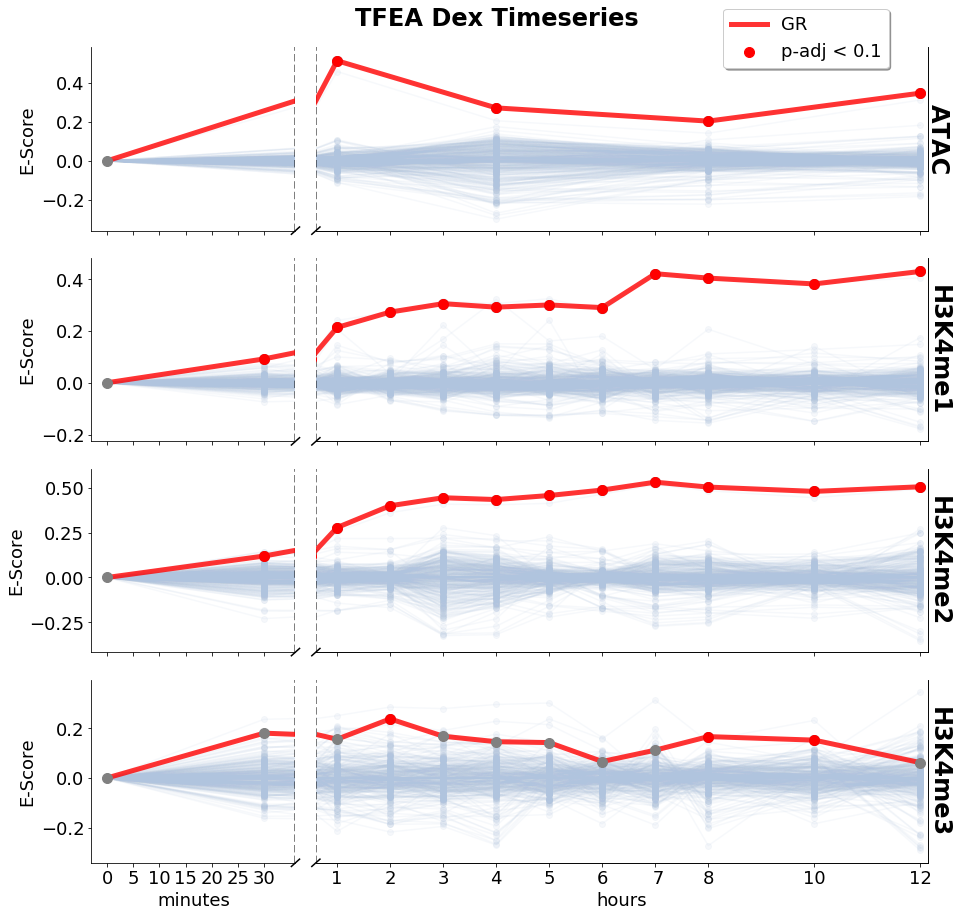

/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/Figures/TFEA_Dex_timeseries_Supp_mumerge_flat.pdf

In [3]:
def parse_results(parent_folder, results_file=None, assay=None, ame=False):
    '''
    Parameters
    ----------
    parent_folder : full path to a folder containing TFEA folders
    beds : dict of dicts with key1 = assay (ATAC, H3K27ac); key2 = treatment time (dex0hr); value = file
    results_file : str : name of tsv file to look for (results.txt, md_results.txt, mdd_results.txt)
    '''
    results = dict()
    for folder in Path(parent_folder).glob('*'):
        info = folder.name.split('_')
        exp = info[0]
        treatment = ''.join(info[1:]).replace('dex0hr', '').replace('hour', 'hr').replace('minute', 'min')
        treatment = 'dex' + treatment if 'dex' not in treatment else treatment
        if exp == assay:
            results[treatment] = list()
            if ame:
                result_file = folder / 'ame' / results_file
            else:
                result_file = folder / results_file
            if ame:
                result_list = [line.split('\t') for line in result_file.read_text().split('\n')[1:] if len(line.split('\t')) > 1 and '#' not in line.split('\t')[0]]
                result_list = [[line[2]] + [x for x in line[5:]] for line in result_list]
            else:
                result_list = [line.split('\t') for line in result_file.read_text().split('\n')[:-1] if '#' not in line[0]]
                result_list = [[line[0]] + [float(x) for x in line[1:-1]] for line in result_list]
            results[treatment].append(result_list)
    return results

def plot_time_results(results, motif=None, outer=None, x_index=2, ame=False, motif_i=0, events_i=3,label='', 
                      ticks=False, p_cut=1e-1, p_i=-1):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer, wspace=0.05, width_ratios=[1,3])
    ax_l = plt.Subplot(F, inner[0])
    ax_r = plt.Subplot(F, inner[1])
    
    sorted_keys = sorted([float(x.strip('dex').strip('min'))/60.0 if 'min' in x else float(x.strip('dex').strip('hr')) for x in results.keys()])
    xvals = [0] + sorted_keys
    sorted_keys = ['dex' + str(int(x)) + 'hr' if x.is_integer() else 'dex' + str(int(x*60.0)) + 'min' for x in sorted_keys]
    
    if ame:
        all_results = [[0 for x2 in x] for x in results[sorted_keys[0]]] + [[[-math.log(float(x2[x_index]),10) if 'e' not in x2[x_index] else float(x2[x_index].split('e')[-1].strip('-')) for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
    else:
        all_results = [[0 for x2 in x] for x in results[sorted_keys[0]]] + [[[x2[x_index] for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
        
    ax_l.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, color='lightsteelblue', alpha=0.1, zorder=1)
    ax_r.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, color='lightsteelblue', alpha=0.1, zorder=1)
    all_results = np.array(all_results).T
    for motif_per_timepoint in all_results:
        ax_l.plot(xvals, motif_per_timepoint, color='lightsteelblue', alpha=0.1, zorder=2)
        ax_r.plot(xvals, motif_per_timepoint, color='lightsteelblue', alpha=0.1, zorder=2)

    if motif != None:
        list_flatten = lambda l: [item for sublist in l for item in sublist]
        if ame:
            motif_results = [[0]] + [[[-math.log(float(x2[x_index]),10) if 'e' not in x2[x_index] else float(x2[x_index].split('e')[-1].strip('-')) for x2 in x if x2[motif_i] == motif] for x in results[key]][0] for key in sorted_keys]
            significant_i = [[[k+1 for x2 in x if x2[motif_i] == motif and float(x2[p_i]) < p_cut] for x in results[sorted_keys[k]]][0] for k in range(len(sorted_keys))]
            significant_i = list_flatten(significant_i)
        else:
            motif_results = [[0]] + [[[x2[x_index] for x2 in x if x2[motif_i] == motif] for x in results[key]][0] for key in sorted_keys]
            significant_i = [[[k+1 for x2 in x if x2[motif_i] == motif and x2[p_i] < p_cut] for x in results[sorted_keys[k]]][0] for k in range(len(sorted_keys))]
            significant_i = list_flatten(significant_i)
            
        ax_l.plot(xvals, motif_results, c='r', alpha=0.8, linewidth=5, label=motif, zorder=3)
        ax_l.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, color='gray', zorder=4)
        if len(significant_i) > 0:
            ax_l.scatter([xvals[i] for i in significant_i], [motif_results[i] for i in significant_i], s=100, color='red', zorder=5)
            ax_r.scatter([xvals[i] for i in significant_i], [motif_results[i] for i in significant_i], s=100, color='red', zorder=5)
        ax_r.plot(xvals, motif_results, c='r', alpha=0.8, linewidth=5, label='GR', zorder=3)
        ax_r.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, color='gray', zorder=4)
    if ticks:
        xticks = [0, 5/60, 10/60, 15/60, 20/60, 25/60, 30/60, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12]
        xlabels = ['0', '5', '10', '15', '20', '25', '30', '1','2', '3', '4', '5', '6',' 7', '8', '10', '12']
        ax_l.get_xaxis().set_ticks(xticks)
        ax_r.get_xaxis().set_ticks(xticks)
        ax_l.set_xticklabels(xlabels)
        ax_r.set_xticklabels(xlabels)
        ax_l.set_xlabel('minutes')
        ax_r.set_xlabel('hours')
    else:
        xticks = [0, 5/60, 10/60, 15/60, 20/60, 25/60, 30/60, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12]
        ax_l.get_xaxis().set_ticks(xticks)
        ax_r.get_xaxis().set_ticks(xticks)
        ax_l.set_xticklabels([])
        ax_r.set_xticklabels([])
    ax_l.set_xlim([-0.05, 0.6])
    ax_r.set_xlim([0.6, 12.15])
    ax_r.axvline(0.6, linestyle='--', c='k', linewidth=2, alpha=0.5)
    limits = [min(ax_l.get_ylim()[0], ax_r.get_ylim()[0]), max(ax_l.get_ylim()[1], ax_r.get_ylim()[1])]
    ax_l.set_ylim(limits)
    ax_r.set_ylim(limits)
    ax_l.axvline(0.6, linestyle='--', c='k', linewidth=2, alpha=0.5)
    
    F.add_subplot(ax_r)
    F.add_subplot(ax_l)
    ax_l.set_ylabel('E-Score')
    ax_r.spines['top'].set_visible(False)
    ax_l.spines['top'].set_visible(False)
    ax_l.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(False)
    ax_r.get_yaxis().set_ticks([])
    #Draw cuts in plot
    d=0.02
    kwargs = dict(transform=ax_l.transAxes, color='k', clip_on=False)
    ax_l.plot((1-d, 1+d), (-d, +d), **kwargs)
    kwargs.update(transform=ax_r.transAxes)
    ax_r.plot((-d/3.0, +d/3.0), (-d, +d), **kwargs)
    
    axR = ax_r.twinx()
    axR.set_ylabel(label, rotation=270, labelpad=22, fontweight='bold', fontsize=24)
    axR.axes.get_yaxis().set_ticks([])
    axR.spines['top'].set_visible(False)
    axR.spines['left'].set_visible(False)
    
    return ax_l, ax_r

#========================================================================================================

F = plt.figure(figsize=(15,15))
outer = gridspec.GridSpec(4, 1, hspace=0.15)

#Plot TFEA results
F.text(0.5, 0.9, 'TFEA Dex Timeseries', ha='center', fontweight='bold', fontsize=24)


output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse2/TFEA/'


results = parse_results(output_folder, results_file='results.txt', assay='ATAC')
ax_l, ax_r = plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[0], label='ATAC')
dummy = ax_r.scatter([0],[0], c='r', s=100, label='p-adj < 0.1')
ax_r.legend(bbox_to_anchor=(0.85, 1.25, 0.1, 0.01), shadow=True)
dummy.remove()

results = parse_results(output_folder, results_file='results.txt', assay='H3K4me1')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[1], label='H3K4me1')

results = parse_results(output_folder, results_file='results.txt', assay='H3K4me2')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[2], label='H3K4me2')

results = parse_results(output_folder, results_file='results.txt', assay='H3K4me3')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[3], label='H3K4me3', ticks=True)

figname = os.path.join(figuredir, 'TFEA_Dex_timeseries_Supp_mumerge.pdf')
F.savefig(figname, bbox_inches='tight', format='pdf')
plt.show()
flattened = flatten(figname)
FileLink(str(Path(flattened).relative_to(Path.cwd())))


## AME Dex Tiemseries

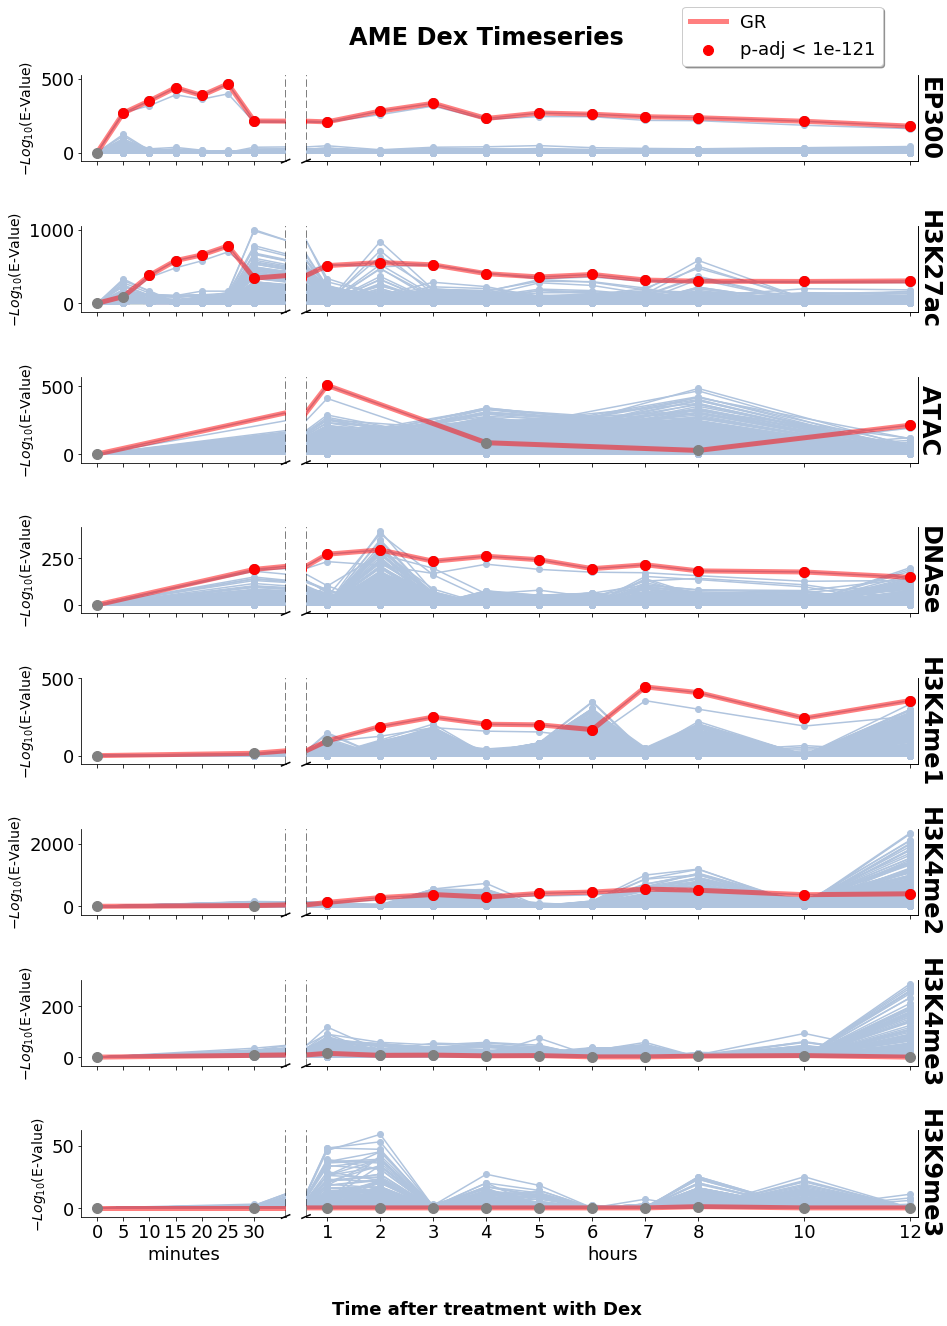

/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/Figures/AME_Dex_timeseries_Supp_mumerge_flat.pdf

In [7]:
def parse_results(parent_folder, results_file=None, assay=None, ame=False):
    '''
    Parameters
    ----------
    parent_folder : full path to a folder containing TFEA folders
    beds : dict of dicts with key1 = assay (ATAC, H3K27ac); key2 = treatment time (dex0hr); value = file
    results_file : str : name of tsv file to look for (ame.tsv, md_ame.tsv, mdd_ame.tsv)
    '''
    results = dict()
    for folder in Path(parent_folder).glob('*'):
        info = folder.name.split('_')
        exp = info[0]
        treatment = ''.join(info[1:]).replace('dex0hr', '').replace('hour', 'hr').replace('minute', 'min')
        treatment = 'dex' + treatment if 'dex' not in treatment else treatment
        if exp == assay:
            results[treatment] = list()
            if ame:
                result_file = folder / 'ame' / results_file
            else:
                result_file = folder / results_file
            if ame:
                result_list = [line.split('\t') for line in result_file.read_text().split('\n')[1:] if len(line.split('\t')) > 1 and '#' not in line.split('\t')[0]]
                result_list = [[line[2]] + [x for x in line[5:]] for line in result_list]
            else:
                result_list = [line.split('\t') for line in result_file.read_text().split('\n')[:-1] if '#' not in line[0]]
                result_list = [[line[0]] + [float(x) for x in line[1:]] for line in result_list]
            results[treatment].append(result_list)
    return results

def plot_time_results(results, motif=None, outer=None, x_index=2, ame=False, motif_i=0, events_i=3,label='', 
                      ticks=False, p_cut=1e-121, p_i=1):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer, wspace=0.05, width_ratios=[1,3])
    ax_l = plt.Subplot(F, inner[0])
    ax_r = plt.Subplot(F, inner[1])
    
    sorted_keys = sorted([float(x.strip('dex').strip('min'))/60.0 if 'min' in x else float(x.strip('dex').strip('hr')) for x in results.keys()])
    xvals = [0] + sorted_keys
    sorted_keys = ['dex' + str(int(x)) + 'hr' if x.is_integer() else 'dex' + str(int(x*60.0)) + 'min' for x in sorted_keys]
    
    if ame:
        all_results = [[0 for x2 in x] for x in results[sorted_keys[0]]] + [[[-math.log(float(x2[x_index]),10) if 'e' not in x2[x_index] else float(x2[x_index].split('e')[-1].strip('-')) for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
    else:
        all_results = [[0 for x2 in x] for x in results[sorted_keys[0]]] + [[[x2[x_index] for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
        
    ax_l.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, color='lightsteelblue', zorder=1)
    ax_r.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, color='lightsteelblue', zorder=1)
    all_results = np.array(all_results).T
    for motif_per_timepoint in all_results:
        ax_l.plot(xvals, motif_per_timepoint, color='lightsteelblue', zorder=2)
        ax_r.plot(xvals, motif_per_timepoint, color='lightsteelblue', zorder=2)

    if motif != None:
        list_flatten = lambda l: [item for sublist in l for item in sublist]
        if ame:
            motif_results = [[0]] + [[[-math.log(float(x2[x_index]),10) if 'e' not in x2[x_index] else float(x2[x_index].split('e')[-1].strip('-')) for x2 in x if x2[motif_i] == motif] for x in results[key]][0] for key in sorted_keys]
            significant_i = [[[k+1 for x2 in x if x2[motif_i] == motif and float(x2[p_i]) < p_cut] for x in results[sorted_keys[k]]][0] for k in range(len(sorted_keys))]
            significant_i = list_flatten(significant_i)
        else:
            motif_results = [[0]] + [[[x2[x_index] for x2 in x if x2[motif_i] == motif] for x in results[key]][0] for key in sorted_keys]
            significant_i = [[[k+1 for x2 in x if x2[motif_i] == motif and x2[p_i] < p_cut] for x in results[sorted_keys[k]]][0] for k in range(len(sorted_keys))]
            significant_i = list_flatten(significant_i)
            
        ax_l.plot(xvals, motif_results, c='r', alpha=0.5, linewidth=5, label='GR', zorder=3)
        ax_l.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, color='gray', zorder=4)
        if len(significant_i) > 0:
            ax_l.scatter([xvals[i] for i in significant_i], [motif_results[i] for i in significant_i], s=100, color='red', zorder=5)
            ax_r.scatter([xvals[i] for i in significant_i], [motif_results[i] for i in significant_i], s=100, color='red', zorder=5)
        ax_r.plot(xvals, motif_results, c='r', alpha=0.5, linewidth=5, label='GR', zorder=3)
        ax_r.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, color='gray', zorder=4)
    if ticks:
        xticks = [0, 5/60, 10/60, 15/60, 20/60, 25/60, 30/60, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12]
        xlabels = ['0','5', '10', '15', '20', '25', '30', '1','2', '3', '4', '5', '6',' 7', '8', '10', '12']
        ax_l.get_xaxis().set_ticks(xticks)
        ax_r.get_xaxis().set_ticks(xticks)
        ax_l.set_xticklabels(xlabels)
        ax_r.set_xticklabels(xlabels)
        ax_l.set_xlabel('minutes')
        ax_r.set_xlabel('hours')
    else:
        xticks = [0, 5/60, 10/60, 15/60, 20/60, 25/60, 30/60, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12]
        ax_l.get_xaxis().set_ticks(xticks)
        ax_r.get_xaxis().set_ticks(xticks)
        ax_l.set_xticklabels([])
        ax_r.set_xticklabels([])
    ax_l.set_xlim([-0.05, 0.6])
    ax_r.set_xlim([0.6, 12.15])
    ax_r.axvline(0.6, linestyle='--', c='k', linewidth=2, alpha=0.5)
    limits = [min(ax_l.get_ylim()[0], ax_r.get_ylim()[0]), max(ax_l.get_ylim()[1], ax_r.get_ylim()[1])]
    ax_l.set_ylim(limits)
    ax_r.set_ylim(limits)
    ax_l.axvline(0.6, linestyle='--', c='k', linewidth=2, alpha=0.5)
    ax_l.set_ylabel('$-Log_{10}$(E-Value)', fontsize=14)
    
    F.add_subplot(ax_r)
    F.add_subplot(ax_l)
    ax_r.spines['top'].set_visible(False)
    ax_l.spines['top'].set_visible(False)
    ax_l.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(False)
    ax_r.get_yaxis().set_ticks([])
    #Draw cuts in plot
    d=0.02
    kwargs = dict(transform=ax_l.transAxes, color='k', clip_on=False)
    ax_l.plot((1-d, 1+d), (-d, +d), **kwargs)
    kwargs.update(transform=ax_r.transAxes)
    ax_r.plot((-d/3.0, +d/3.0), (-d, +d), **kwargs)
    
    axR = ax_r.twinx()
    axR.set_ylabel(label, rotation=270, labelpad=22, fontweight='bold', fontsize=24)
    axR.axes.get_yaxis().set_ticks([])
    axR.spines['top'].set_visible(False)
    axR.spines['left'].set_visible(False)
    
    return ax_l, ax_r

#========================================================================================================

F = plt.figure(figsize=(15,21))
outer = gridspec.GridSpec(8, 1, hspace=0.75)

#Plot TFEA results
F.text(0.5, 0.9, f'AME Dex Timeseries', ha='center', fontweight='bold', fontsize=24)
# F.text(0.05, 0.5, '$-Log_{10}$(E-Value)', va='center', rotation=90, fontsize=24)

i = 0
output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse2/TFEA'
results = parse_results(output_folder, results_file='ame.tsv', assay='EP300', ame=True)
ax_l, ax_r = plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='EP300', ame=True)
dummy = ax_r.scatter([0],[0], c='r', s=100, label='p-adj < 1e-121')
ax_r.legend(bbox_to_anchor=(0.6, 1, 0.1, 0.01), shadow=True)
dummy.remove()
i+=1


# output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse2/TFEA/'
results = parse_results(output_folder, results_file='ame.tsv', assay='H3K27ac', ame=True)
ax_l, ax_r = plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K27ac', ame=True)
i+=1

results = parse_results(output_folder, results_file='ame.tsv', assay='ATAC', ame=True)
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='ATAC', ticks=False, ame=True)
i+=1

# output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/DNAse/TFEA/'
results = parse_results(output_folder, results_file='ame.tsv', assay='DNa', ame=True)
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='DNAse', ticks=False, ame=True)
i+=1

# output_folder = '/scratch/Shares/dowell/for_jonathan'
results = parse_results(output_folder, results_file='ame.tsv', assay='H3K4me1', ame=True)
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K4me1', ame=True)
i+=1

results = parse_results(output_folder, results_file='ame.tsv', assay='H3K4me2', ame=True)
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K4me2', ame=True)
i+=1

results = parse_results(output_folder, results_file='ame.tsv', assay='H3K4me3', ame=True)
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K4me3', ame=True)
i+=1

results = parse_results(output_folder, results_file='ame.tsv', assay='H3K9me3', ame=True)
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K9me3', ticks=True, ame=True)
F.text(0.5, 0.06, 'Time after treatment with Dex', ha='center', fontweight='bold')
i+=1

# output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/GCR/TFEA/'
# results = parse_results(output_folder, results_file='ame.tsv', assay='NR3C1', ame=True)
# plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[7], label='GCR', ticks=True, ame=True)

figname = os.path.join(figuredir, 'AME_Dex_timeseries_Supp_mumerge.pdf')
F.savefig(figname, bbox_inches='tight', format='pdf')
plt.show()
flattened = flatten(figname)
FileLink(str(Path(flattened).relative_to(Path.cwd())))


## MD-Score Dex Timeseries

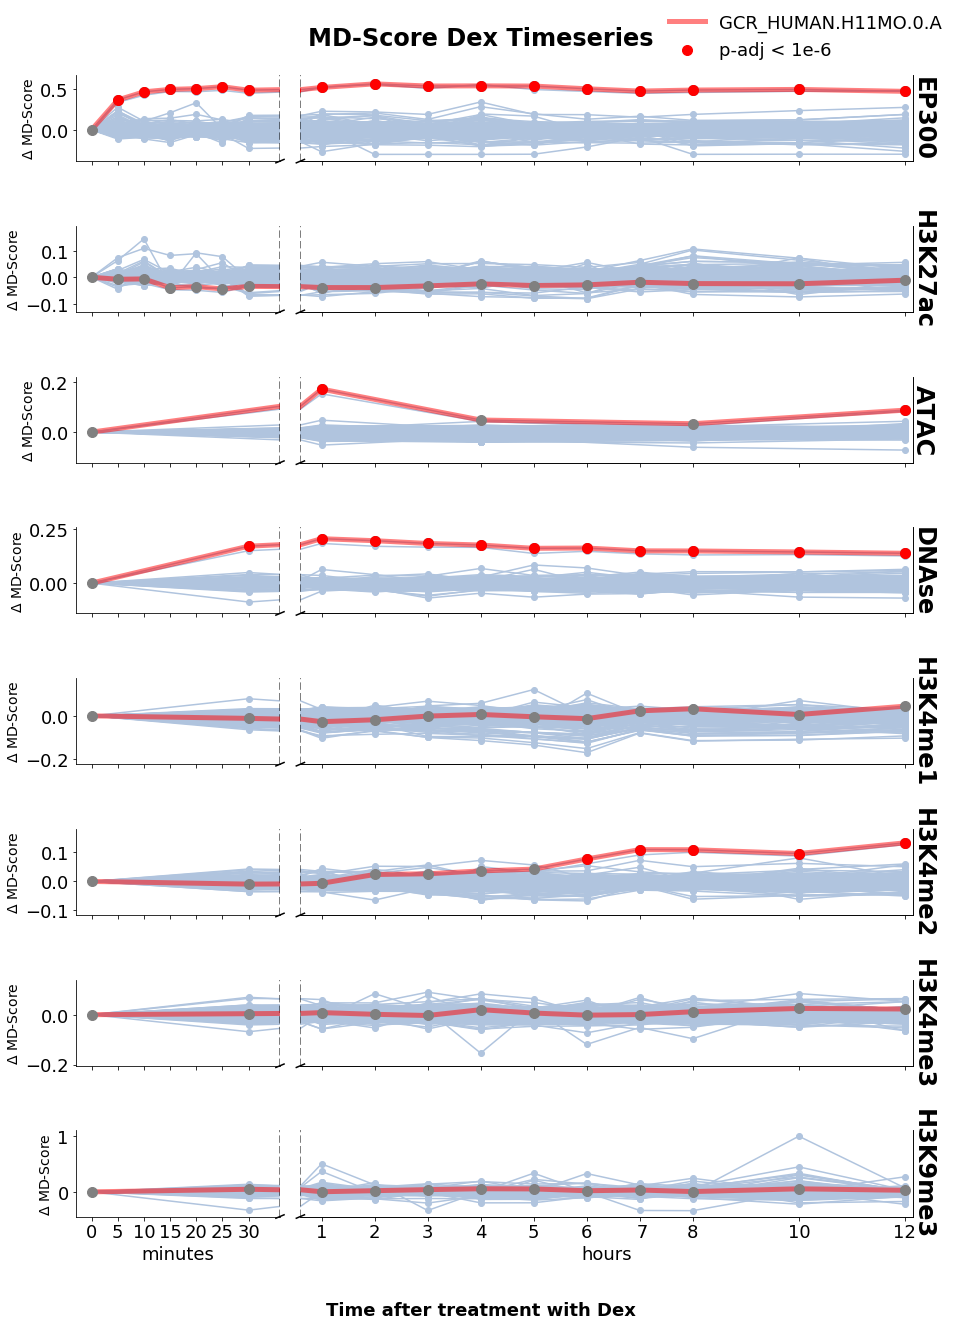

/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/Figures/MD_Dex_timeseries_Supp_mumerge_flat.pdf

In [10]:
def parse_results(parent_folder, results_file=None, assay=None, ame=False):
    '''
    Parameters
    ----------
    parent_folder : full path to a folder containing TFEA folders
    beds : dict of dicts with key1 = assay (ATAC, H3K27ac); key2 = treatment time (dex0hr); value = file
    results_file : str : name of tsv file to look for (ame.tsv, md_ame.tsv, mdd_ame.tsv)
    '''
    results = dict()
    for folder in Path(parent_folder).glob('*'):
        info = folder.name.split('_')
        exp = info[0]
        treatment = ''.join(info[1:]).replace('dex0hr', '').replace('hour', 'hr').replace('minute', 'min')
        treatment = 'dex' + treatment if 'dex' not in treatment else treatment
        if exp == assay:
            results[treatment] = list()
            if ame:
                result_file = folder / 'ame' / results_file
            else:
                result_file = folder / results_file
            if ame:
                result_list = [line.split('\t') for line in result_file.read_text().split('\n')[1:] if len(line.split('\t')) > 1 and '#' not in line.split('\t')[0]]
                result_list = [[line[2]] + [x for x in line[5:]] for line in result_list]
            else:
                result_list = [line.split('\t') for line in result_file.read_text().split('\n')[:-1] if '#' not in line[0]]
                result_list = [[line[0]] + [float(x) for x in line[1:]] for line in result_list]
            results[treatment].append(result_list)
    return results

def plot_time_results(results, motif=None, outer=None, x_index=2, ame=False, motif_i=0, events_i=3,label='', 
                      ticks=False, p_cut=1e-6, p_i=-1):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer, wspace=0.05, width_ratios=[1,3])
    ax_l = plt.Subplot(F, inner[0])
    ax_r = plt.Subplot(F, inner[1])
    
    sorted_keys = sorted([float(x.strip('dex').strip('min'))/60.0 if 'min' in x else float(x.strip('dex').strip('hr')) for x in results.keys()])
    xvals = [0] + sorted_keys
    sorted_keys = ['dex' + str(int(x)) + 'hr' if x.is_integer() else 'dex' + str(int(x*60.0)) + 'min' for x in sorted_keys]
    
    if ame:
        all_results = [[0 for x2 in x] for x in results[sorted_keys[0]]] + [[[-math.log(float(x2[x_index]),10) if 'e' not in x2[x_index] else float(x2[x_index].split('e')[-1].strip('-')) for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
    else:
        all_results = [[0 for x2 in x] for x in results[sorted_keys[0]]] + [[[x2[x_index] for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
        
    ax_l.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, color='lightsteelblue', zorder=1)
    ax_r.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, color='lightsteelblue', zorder=1)
    all_results = np.array(all_results).T
    for motif_per_timepoint in all_results:
        ax_l.plot(xvals, motif_per_timepoint, color='lightsteelblue', zorder=2)
        ax_r.plot(xvals, motif_per_timepoint, color='lightsteelblue', zorder=2)

    if motif != None:
        list_flatten = lambda l: [item for sublist in l for item in sublist]
        if ame:
            motif_results = [[0]] + [[[-math.log(float(x2[x_index]),10) if 'e' not in x2[x_index] else float(x2[x_index].split('e')[-1].strip('-')) for x2 in x if x2[motif_i] == motif] for x in results[key]][0] for key in sorted_keys]
            significant_i = [[[k+1 for x2 in x if x2[motif_i] == motif and float(x2[p_i]) < p_cut] for x in results[sorted_keys[k]]][0] for k in range(len(sorted_keys))]
            significant_i = list_flatten(significant_i)
        else:
            motif_results = [[0]] + [[[x2[x_index] for x2 in x if x2[motif_i] == motif] for x in results[key]][0] for key in sorted_keys]
            significant_i = [[[k+1 for x2 in x if x2[motif_i] == motif and x2[p_i] < p_cut] for x in results[sorted_keys[k]]][0] for k in range(len(sorted_keys))]
            significant_i = list_flatten(significant_i)
            
        ax_l.plot(xvals, motif_results, c='r', alpha=0.5, linewidth=5, label=motif, zorder=3)
        ax_l.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, color='gray', zorder=4)
        if len(significant_i) > 0:
            ax_l.scatter([xvals[i] for i in significant_i], [motif_results[i] for i in significant_i], s=100, color='red', zorder=5)
            ax_r.scatter([xvals[i] for i in significant_i], [motif_results[i] for i in significant_i], s=100, color='red', zorder=5)
        ax_r.plot(xvals, motif_results, c='r', alpha=0.5, linewidth=5, label=motif, zorder=3)
        ax_r.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, color='gray', zorder=4)
    if ticks:
        xticks = [0, 5/60, 10/60, 15/60, 20/60, 25/60, 30/60, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12]
        xlabels = ['0','5', '10', '15', '20', '25', '30', '1','2', '3', '4', '5', '6',' 7', '8', '10', '12']
        ax_l.get_xaxis().set_ticks(xticks)
        ax_r.get_xaxis().set_ticks(xticks)
        ax_l.set_xticklabels(xlabels)
        ax_r.set_xticklabels(xlabels)
        ax_l.set_xlabel('minutes')
        ax_r.set_xlabel('hours')
    else:
        xticks = [0, 5/60, 10/60, 15/60, 20/60, 25/60, 30/60, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12]
        ax_l.get_xaxis().set_ticks(xticks)
        ax_r.get_xaxis().set_ticks(xticks)
        ax_l.set_xticklabels([])
        ax_r.set_xticklabels([])
    ax_l.set_xlim([-0.05, 0.6])
    ax_r.set_xlim([0.6, 12.15])
    ax_r.axvline(0.6, linestyle='--', c='k', linewidth=2, alpha=0.5)
    limits = [min(ax_l.get_ylim()[0], ax_r.get_ylim()[0]), max(ax_l.get_ylim()[1], ax_r.get_ylim()[1])]
    ax_l.set_ylim(limits)
    ax_r.set_ylim(limits)
    ax_l.axvline(0.6, linestyle='--', c='k', linewidth=2, alpha=0.5)
    ax_l.set_ylabel('$\Delta$ MD-Score', fontsize=14)
    
    F.add_subplot(ax_r)
    F.add_subplot(ax_l)
    ax_r.spines['top'].set_visible(False)
    ax_l.spines['top'].set_visible(False)
    ax_l.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(False)
    ax_r.get_yaxis().set_ticks([])
    #Draw cuts in plot
    d=0.02
    kwargs = dict(transform=ax_l.transAxes, color='k', clip_on=False)
    ax_l.plot((1-d, 1+d), (-d, +d), **kwargs)
    kwargs.update(transform=ax_r.transAxes)
    ax_r.plot((-d/3.0, +d/3.0), (-d, +d), **kwargs)
    
    axR = ax_r.twinx()
    axR.set_ylabel(label, rotation=270, labelpad=22, fontweight='bold', fontsize=24)
    axR.axes.get_yaxis().set_ticks([])
    axR.spines['top'].set_visible(False)
    axR.spines['left'].set_visible(False)
    
    return ax_l, ax_r

#========================================================================================================

F = plt.figure(figsize=(15,21))
outer = gridspec.GridSpec(8, 1, hspace=0.75)

#Plot TFEA results
F.text(0.5, 0.9, f'MD-Score Dex Timeseries', ha='center', fontweight='bold', fontsize=24)
# F.text(0.05, 0.5, '$-Log_{10}$(E-Value)', va='center', rotation=90, fontsize=24)

i = 0
output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse2/TFEA'
results = parse_results(output_folder, results_file='md_results.txt', assay='EP300')
ax_l, ax_r = plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='EP300', x_index=1)
dummy = ax_r.scatter([0],[0], c='r', s=100, label='p-adj < 1e-6')
ax_r.legend(bbox_to_anchor=(0.575, 1, 0.1, 0.01), frameon=False)
dummy.remove()
i+=1


# output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse2/TFEA/'
results = parse_results(output_folder, results_file='md_results.txt', assay='H3K27ac')
ax_l, ax_r = plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K27ac', x_index=1)
i+=1

results = parse_results(output_folder, results_file='md_results.txt', assay='ATAC')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='ATAC', x_index=1)
i+=1

# output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/DNAse/TFEA/'
results = parse_results(output_folder, results_file='md_results.txt', assay='DNa')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='DNAse', x_index=1)
i+=1

# output_folder = '/scratch/Shares/dowell/for_jonathan'
results = parse_results(output_folder, results_file='md_results.txt', assay='H3K4me1')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K4me1', x_index=1)
i+=1

results = parse_results(output_folder, results_file='md_results.txt', assay='H3K4me2')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K4me2', x_index=1)
i+=1

results = parse_results(output_folder, results_file='md_results.txt', assay='H3K4me3')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K4me3', x_index=1)
i+=1

results = parse_results(output_folder, results_file='md_results.txt', assay='H3K9me3')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K9me3', ticks=True, x_index=1)
F.text(0.5, 0.06, 'Time after treatment with Dex', ha='center', fontweight='bold')
i+=1

# output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/GCR/TFEA/'
# results = parse_results(output_folder, results_file='md_results.txt', assay='NR3C1')
# plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[7], label='GCR', ticks=True)

figname = os.path.join(figuredir, 'MD_Dex_timeseries_Supp_mumerge.pdf')
F.savefig(figname, bbox_inches='tight', format='pdf')
plt.show()
flattened = flatten(figname)
FileLink(str(Path(flattened).relative_to(Path.cwd())))


## MDD-Score Dex Timeseries

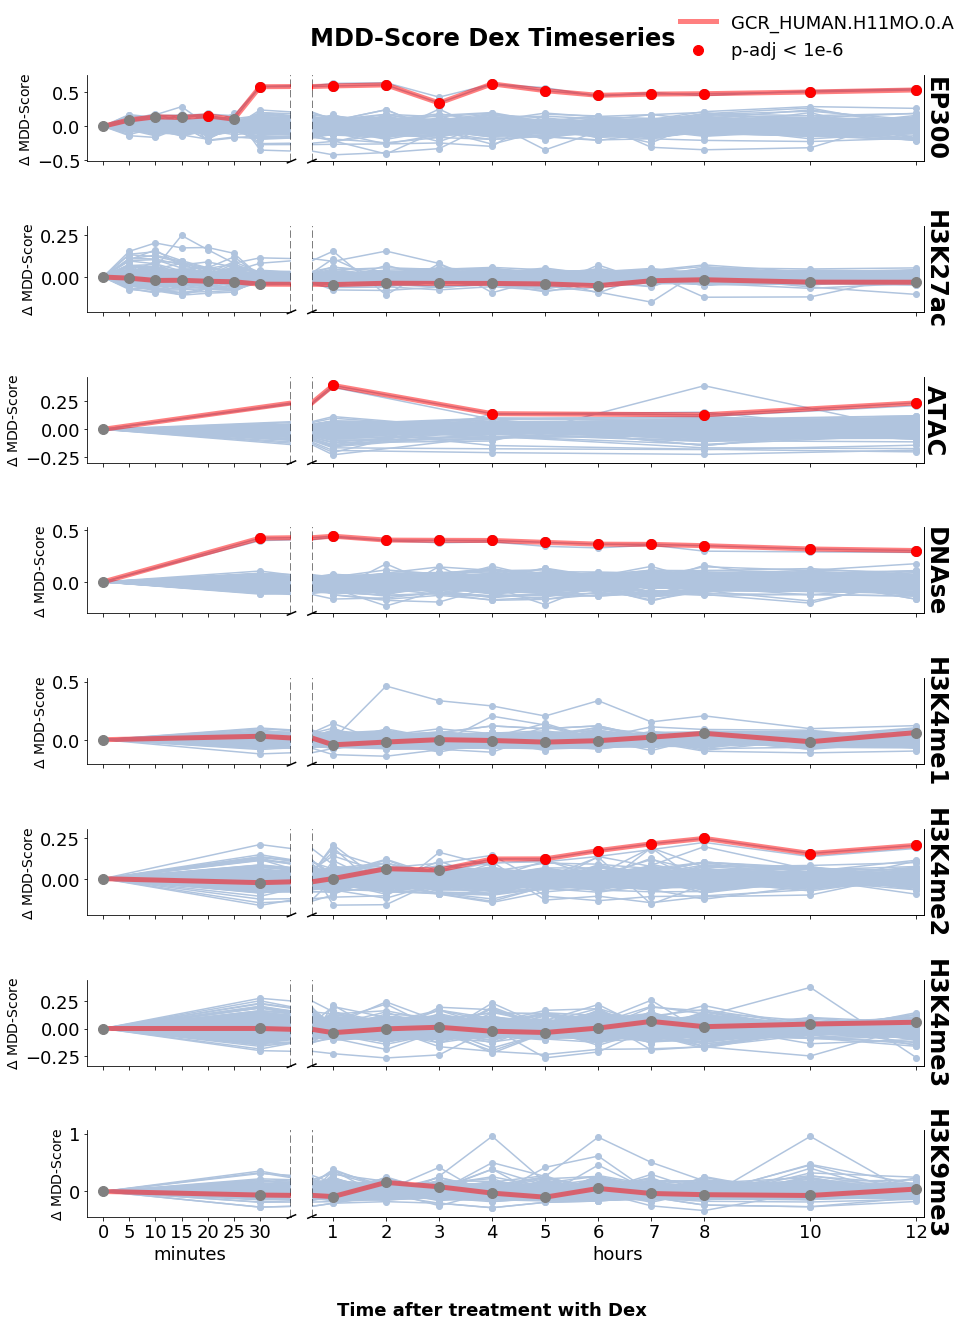

/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/Figures/MDD_Dex_timeseries_Supp_mumerge_flat.pdf

In [11]:
def parse_results(parent_folder, results_file=None, assay=None, ame=False):
    '''
    Parameters
    ----------
    parent_folder : full path to a folder containing TFEA folders
    beds : dict of dicts with key1 = assay (ATAC, H3K27ac); key2 = treatment time (dex0hr); value = file
    results_file : str : name of tsv file to look for (ame.tsv, md_ame.tsv, mdd_ame.tsv)
    '''
    results = dict()
    for folder in Path(parent_folder).glob('*'):
        info = folder.name.split('_')
        exp = info[0]
        treatment = ''.join(info[1:]).replace('dex0hr', '').replace('hour', 'hr').replace('minute', 'min')
        treatment = 'dex' + treatment if 'dex' not in treatment else treatment
        if exp == assay:
            results[treatment] = list()
            if ame:
                result_file = folder / 'ame' / results_file
            else:
                result_file = folder / results_file
            if ame:
                result_list = [line.split('\t') for line in result_file.read_text().split('\n')[1:] if len(line.split('\t')) > 1 and '#' not in line.split('\t')[0]]
                result_list = [[line[2]] + [x for x in line[5:]] for line in result_list]
            else:
                result_list = [line.split('\t') for line in result_file.read_text().split('\n')[:-1] if '#' not in line[0]]
                result_list = [[line[0]] + [float(x) for x in line[1:]] for line in result_list]
            results[treatment].append(result_list)
    return results

def plot_time_results(results, motif=None, outer=None, x_index=2, ame=False, motif_i=0, events_i=3,label='', 
                      ticks=False, p_cut=1e-6, p_i=-1):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer, wspace=0.05, width_ratios=[1,3])
    ax_l = plt.Subplot(F, inner[0])
    ax_r = plt.Subplot(F, inner[1])
    
    sorted_keys = sorted([float(x.strip('dex').strip('min'))/60.0 if 'min' in x else float(x.strip('dex').strip('hr')) for x in results.keys()])
    xvals = [0] + sorted_keys
    sorted_keys = ['dex' + str(int(x)) + 'hr' if x.is_integer() else 'dex' + str(int(x*60.0)) + 'min' for x in sorted_keys]
    
    if ame:
        all_results = [[0 for x2 in x] for x in results[sorted_keys[0]]] + [[[-math.log(float(x2[x_index]),10) if 'e' not in x2[x_index] else float(x2[x_index].split('e')[-1].strip('-')) for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
    else:
        all_results = [[0 for x2 in x] for x in results[sorted_keys[0]]] + [[[x2[x_index] for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
        
    ax_l.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, color='lightsteelblue', zorder=1)
    ax_r.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, color='lightsteelblue', zorder=1)
    all_results = np.array(all_results).T
    for motif_per_timepoint in all_results:
        ax_l.plot(xvals, motif_per_timepoint, color='lightsteelblue', zorder=2)
        ax_r.plot(xvals, motif_per_timepoint, color='lightsteelblue', zorder=2)

    if motif != None:
        list_flatten = lambda l: [item for sublist in l for item in sublist]
        if ame:
            motif_results = [[0]] + [[[-math.log(float(x2[x_index]),10) if 'e' not in x2[x_index] else float(x2[x_index].split('e')[-1].strip('-')) for x2 in x if x2[motif_i] == motif] for x in results[key]][0] for key in sorted_keys]
            significant_i = [[[k+1 for x2 in x if x2[motif_i] == motif and float(x2[p_i]) < p_cut] for x in results[sorted_keys[k]]][0] for k in range(len(sorted_keys))]
            significant_i = list_flatten(significant_i)
        else:
            motif_results = [[0]] + [[[x2[x_index] for x2 in x if x2[motif_i] == motif] for x in results[key]][0] for key in sorted_keys]
            significant_i = [[[k+1 for x2 in x if x2[motif_i] == motif and x2[p_i] < p_cut] for x in results[sorted_keys[k]]][0] for k in range(len(sorted_keys))]
            significant_i = list_flatten(significant_i)
            
        ax_l.plot(xvals, motif_results, c='r', alpha=0.5, linewidth=5, label=motif, zorder=3)
        ax_l.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, color='gray', zorder=4)
        if len(significant_i) > 0:
            ax_l.scatter([xvals[i] for i in significant_i], [motif_results[i] for i in significant_i], s=100, color='red', zorder=5)
            ax_r.scatter([xvals[i] for i in significant_i], [motif_results[i] for i in significant_i], s=100, color='red', zorder=5)
        ax_r.plot(xvals, motif_results, c='r', alpha=0.5, linewidth=5, label=motif, zorder=3)
        ax_r.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, color='gray', zorder=4)
    if ticks:
        xticks = [0, 5/60, 10/60, 15/60, 20/60, 25/60, 30/60, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12]
        xlabels = ['0','5', '10', '15', '20', '25', '30', '1','2', '3', '4', '5', '6',' 7', '8', '10', '12']
        ax_l.get_xaxis().set_ticks(xticks)
        ax_r.get_xaxis().set_ticks(xticks)
        ax_l.set_xticklabels(xlabels)
        ax_r.set_xticklabels(xlabels)
        ax_l.set_xlabel('minutes')
        ax_r.set_xlabel('hours')
    else:
        xticks = [0, 5/60, 10/60, 15/60, 20/60, 25/60, 30/60, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12]
        ax_l.get_xaxis().set_ticks(xticks)
        ax_r.get_xaxis().set_ticks(xticks)
        ax_l.set_xticklabels([])
        ax_r.set_xticklabels([])
    ax_l.set_xlim([-0.05, 0.6])
    ax_r.set_xlim([0.6, 12.15])
    ax_r.axvline(0.6, linestyle='--', c='k', linewidth=2, alpha=0.5)
    limits = [min(ax_l.get_ylim()[0], ax_r.get_ylim()[0]), max(ax_l.get_ylim()[1], ax_r.get_ylim()[1])]
    ax_l.set_ylim(limits)
    ax_r.set_ylim(limits)
    ax_l.axvline(0.6, linestyle='--', c='k', linewidth=2, alpha=0.5)
    ax_l.set_ylabel('$\Delta$ MDD-Score', fontsize=14)
    
    F.add_subplot(ax_r)
    F.add_subplot(ax_l)
    ax_r.spines['top'].set_visible(False)
    ax_l.spines['top'].set_visible(False)
    ax_l.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(False)
    ax_r.get_yaxis().set_ticks([])
    #Draw cuts in plot
    d=0.02
    kwargs = dict(transform=ax_l.transAxes, color='k', clip_on=False)
    ax_l.plot((1-d, 1+d), (-d, +d), **kwargs)
    kwargs.update(transform=ax_r.transAxes)
    ax_r.plot((-d/3.0, +d/3.0), (-d, +d), **kwargs)
    
    axR = ax_r.twinx()
    axR.set_ylabel(label, rotation=270, labelpad=22, fontweight='bold', fontsize=24)
    axR.axes.get_yaxis().set_ticks([])
    axR.spines['top'].set_visible(False)
    axR.spines['left'].set_visible(False)
    
    return ax_l, ax_r

#========================================================================================================

F = plt.figure(figsize=(15,21))
outer = gridspec.GridSpec(8, 1, hspace=0.75)

#Plot TFEA results
F.text(0.5, 0.9, f'MDD-Score Dex Timeseries', ha='center', fontweight='bold', fontsize=24)
# F.text(0.05, 0.5, '$-Log_{10}$(E-Value)', va='center', rotation=90, fontsize=24)

i = 0
output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse2/TFEA'
results = parse_results(output_folder, results_file='mdd_results.txt', assay='EP300')
ax_l, ax_r = plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='EP300', x_index=1)
dummy = ax_r.scatter([0],[0], c='r', s=100, label='p-adj < 1e-6')
ax_r.legend(bbox_to_anchor=(0.575, 1, 0.1, 0.01), frameon=False)
dummy.remove()
i+=1


# output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse2/TFEA/'
results = parse_results(output_folder, results_file='mdd_results.txt', assay='H3K27ac')
ax_l, ax_r = plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K27ac', x_index=1)
i+=1

results = parse_results(output_folder, results_file='mdd_results.txt', assay='ATAC')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='ATAC', x_index=1)
i+=1

# output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/DNAse/TFEA/'
results = parse_results(output_folder, results_file='mdd_results.txt', assay='DNa')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='DNAse', x_index=1)
i+=1

# output_folder = '/scratch/Shares/dowell/for_jonathan'
results = parse_results(output_folder, results_file='mdd_results.txt', assay='H3K4me1')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K4me1', x_index=1)
i+=1

results = parse_results(output_folder, results_file='mdd_results.txt', assay='H3K4me2')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K4me2', x_index=1)
i+=1

results = parse_results(output_folder, results_file='mdd_results.txt', assay='H3K4me3')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K4me3', x_index=1)
i+=1

results = parse_results(output_folder, results_file='mdd_results.txt', assay='H3K9me3')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[i], label='H3K9me3', ticks=True, x_index=1)
F.text(0.5, 0.06, 'Time after treatment with Dex', ha='center', fontweight='bold')
i+=1

# output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/GCR/TFEA/'
# results = parse_results(output_folder, results_file='md_results.txt', assay='NR3C1')
# plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[7], label='GCR', ticks=True)

figname = os.path.join(figuredir, 'MDD_Dex_timeseries_Supp_mumerge.pdf')
F.savefig(figname, bbox_inches='tight', format='pdf')
plt.show()
flattened = flatten(figname)
FileLink(str(Path(flattened).relative_to(Path.cwd())))


# Additional Analysis

## TFEA run on TF ChIP data

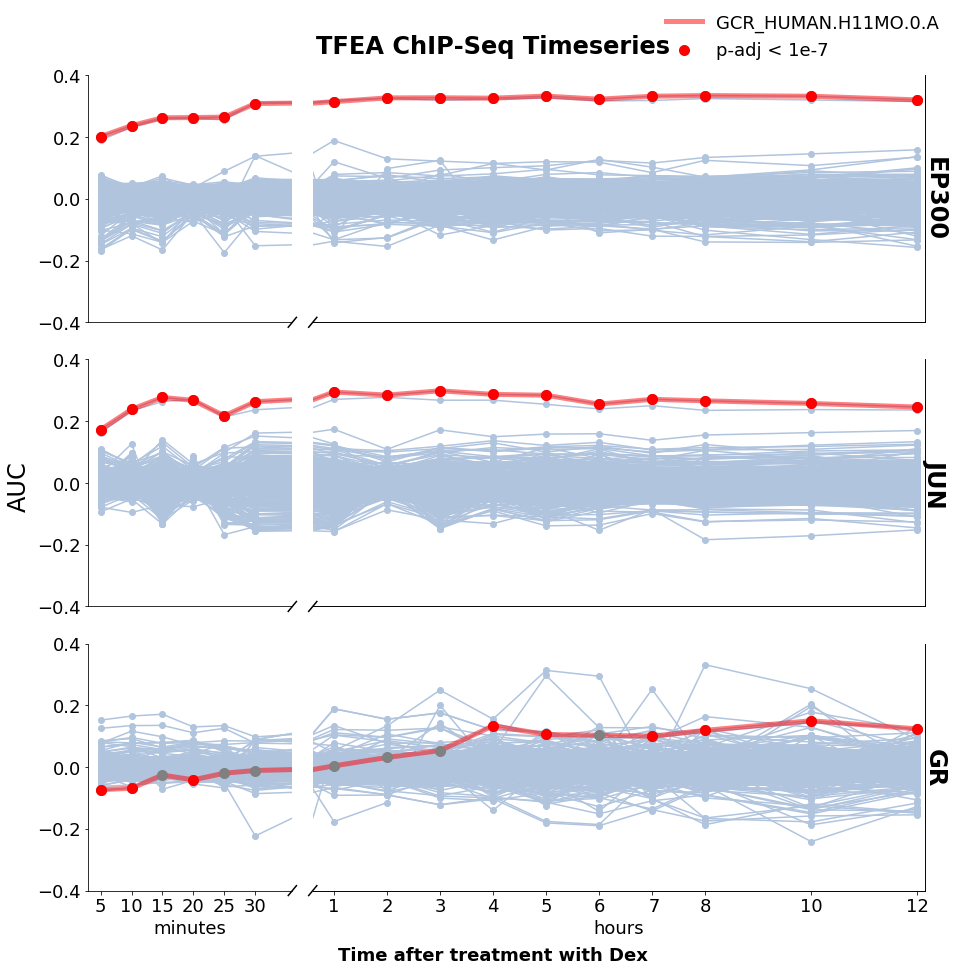

/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/Figures/TFEA_ChIP_timeseries_flat.pdf

In [7]:
def parse_results(parent_folder, results_file=None, assay=None, ame=False):
    '''
    Parameters
    ----------
    parent_folder : full path to a folder containing TFEA folders
    beds : dict of dicts with key1 = assay (ATAC, H3K27ac); key2 = treatment time (dex0hr); value = file
    results_file : str : name of tsv file to look for (results.txt, md_results.txt, mdd_results.txt)
    '''
    results = dict()
    for folder in Path(parent_folder).glob('*'):
        info = folder.name.split('_')
        exp = info[0]
        treatment = ''.join(info[1:]).replace('dex0hr', '').replace('hour', 'hr').replace('minute', 'min')
        treatment = 'dex' + treatment if 'dex' not in treatment else treatment
        if exp == assay:
            results[treatment] = list()
            if ame:
                result_file = folder / 'ame' / results_file
            else:
                result_file = folder / results_file
            if ame:
                result_list = [line.split('\t') for line in result_file.read_text().split('\n')[1:] if len(line.split('\t')) > 1 and '#' not in line.split('\t')[0]]
                result_list = [[line[2]] + [x for x in line[5:]] for line in result_list]
            else:
                result_list = [line.split('\t') for line in result_file.read_text().split('\n')[:-1] if '#' not in line[0]]
                result_list = [[line[0]] + [float(x) for x in line[1:]] for line in result_list]
            results[treatment].append(result_list)
    return results

def plot_time_results(results, motif=None, outer=None, x_index=2, ame=False, motif_i=0, events_i=3,label='', 
                      ticks=False, p_cut=1e-7, p_i=-1):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer, wspace=0.05, width_ratios=[1,3])
    ax_l = plt.Subplot(F, inner[0])
    ax_r = plt.Subplot(F, inner[1])
    
    sorted_keys = sorted([float(x.strip('dex').strip('min'))/60.0 if 'min' in x else float(x.strip('dex').strip('hr')) for x in results.keys()])
    xvals = sorted_keys
    sorted_keys = ['dex' + str(int(x)) + 'hr' if x.is_integer() else 'dex' + str(int(x*60.0)) + 'min' for x in sorted_keys]
    
    if ame:
        all_results = [[[-math.log(float(x2[x_index]),10) if 'e' not in x2[x_index] else float(x2[x_index].split('e')[-1].strip('-')) for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
    else:
        all_results = [[[x2[x_index] for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
        
    ax_l.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, color='lightsteelblue', zorder=1)
    ax_r.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, color='lightsteelblue', zorder=1)
    all_results = np.array(all_results).T
    for motif_per_timepoint in all_results:
        ax_l.plot(xvals, motif_per_timepoint, color='lightsteelblue', zorder=2)
        ax_r.plot(xvals, motif_per_timepoint, color='lightsteelblue', zorder=2)

    if motif != None:
        list_flatten = lambda l: [item for sublist in l for item in sublist]
        if ame:
            motif_results = [[0]] + [[[-math.log(float(x2[x_index]),10) if 'e' not in x2[x_index] else float(x2[x_index].split('e')[-1].strip('-')) for x2 in x if x2[motif_i] == motif] for x in results[key]][0] for key in sorted_keys]
            significant_i = [[[k+1 for x2 in x if x2[motif_i] == motif and float(x2[p_i]) < p_cut] for x in results[sorted_keys[k]]][0] for k in range(len(sorted_keys))]
            significant_i = list_flatten(significant_i)
        else:
            motif_results = [[[x2[x_index] for x2 in x if x2[motif_i] == motif] for x in results[key]][0] for key in sorted_keys]
            significant_i = [[[k for x2 in x if x2[motif_i] == motif and x2[p_i] < p_cut] for x in results[sorted_keys[k]]][0] for k in range(len(sorted_keys))]
            significant_i = list_flatten(significant_i)
            
        ax_l.plot(xvals, motif_results, c='r', alpha=0.5, linewidth=5, label=motif, zorder=3)
        ax_l.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, color='gray', zorder=4)
        if len(significant_i) > 0:
            ax_l.scatter([xvals[i] for i in significant_i], [motif_results[i] for i in significant_i], s=100, color='red', zorder=5)
            ax_r.scatter([xvals[i] for i in significant_i], [motif_results[i] for i in significant_i], s=100, color='red', zorder=5)
        ax_r.plot(xvals, motif_results, c='r', alpha=0.5, linewidth=5, label=motif, zorder=3)
        ax_r.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, color='gray', zorder=4)
    if ticks:
        xticks = [0, 5/60, 10/60, 15/60, 20/60, 25/60, 30/60, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12]
        xlabels = ['0','5', '10', '15', '20', '25', '30', '1','2', '3', '4', '5', '6',' 7', '8', '10', '12']
        ax_l.get_xaxis().set_ticks(xticks)
        ax_r.get_xaxis().set_ticks(xticks)
        ax_l.set_xticklabels(xlabels)
        ax_r.set_xticklabels(xlabels)
        ax_l.set_xlabel('minutes')
        ax_r.set_xlabel('hours')
    else:
        ax_l.get_xaxis().set_ticks([])
        ax_r.get_xaxis().set_ticks([])
        ax_l.set_xticklabels([])
        ax_r.set_xticklabels([])
    ax_l.set_xlim([0.05, 0.6])
    ax_r.set_xlim([0.6, 12.15])
    ax_l.set_ylim([-0.4, 0.4])
    ax_r.set_ylim([-0.4, 0.4])
    
    F.add_subplot(ax_r)
    F.add_subplot(ax_l)
    ax_r.spines['top'].set_visible(False)
    ax_l.spines['top'].set_visible(False)
    ax_l.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(False)
    ax_r.get_yaxis().set_ticks([])
    #Draw cuts in plot
    d=0.02
    kwargs = dict(transform=ax_l.transAxes, color='k', clip_on=False)
    ax_l.plot((1-d, 1+d), (-d, +d), **kwargs)
    kwargs.update(transform=ax_r.transAxes)
    ax_r.plot((-d/3.0, +d/3.0), (-d, +d), **kwargs)
    
    axR = ax_r.twinx()
    axR.set_ylabel(label, rotation=270, labelpad=22, fontweight='bold', fontsize=24)
    axR.axes.get_yaxis().set_ticks([])
    axR.spines['top'].set_visible(False)
    axR.spines['left'].set_visible(False)
    
    return ax_l, ax_r

#========================================================================================================

F = plt.figure(figsize=(15,15))
outer = gridspec.GridSpec(3, 1, hspace=0.15)

#Plot TFEA results
F.text(0.5, 0.9, 'TFEA ChIP-Seq Timeseries', ha='center', fontweight='bold', fontsize=24)
F.text(0.05, 0.5, 'AUC', va='center', rotation=90, fontsize=24)
output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/TF_ChIP/TFEA/'
results = parse_results(output_folder, results_file='results.txt', assay='EP300')
ax_l, ax_r = plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[0], label='EP300')
dummy = ax_r.scatter([0],[0], c='r', s=100, label='p-adj < 1e-7')
ax_r.legend(bbox_to_anchor=(0.55, 1, 0.1, 0.01), frameon=False)
dummy.remove()

results = parse_results(output_folder, results_file='results.txt', assay='NR3C1')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[2], label='GR', ticks=True)


results = parse_results(output_folder, results_file='results.txt', assay='JUN')
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[1], label='JUN', ticks=False)

# output_folder = '/scratch/Shares/dowell/for_jonathan'
# results = parse_results(output_folder, results_file='results.txt', assay='H3K4me1')
# plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[3], label='H3K4me1')

# results = parse_results(output_folder, results_file='results.txt', assay='H3K4me2')
# plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[4], label='H3K4me2')

# results = parse_results(output_folder, results_file='results.txt', assay='H3K4me3')
# plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[5], label='H3K4me3')

# results = parse_results(output_folder, results_file='results.txt', assay='H3K9me3')
# plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[6], label='H3K9me3', ticks=True)
F.text(0.5, 0.06, 'Time after treatment with Dex', ha='center', fontweight='bold')

# output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/GCR/TFEA/'
# results = parse_results(output_folder, results_file='results.txt', assay='NR3C1')
# plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[7], label='GCR', ticks=True)

figname = os.path.join(figuredir, 'TFEA_ChIP_timeseries.pdf')
F.savefig(figname, bbox_inches='tight', format='pdf')
plt.show()
flattened = flatten(figname)
FileLink(str(Path(flattened).relative_to(Path.cwd())))


## DE-Seq MA plot of GR ChIP Peaks
Note this image generated by running TFEA on NR3C1 ChIP-Seq data from ENCODE.

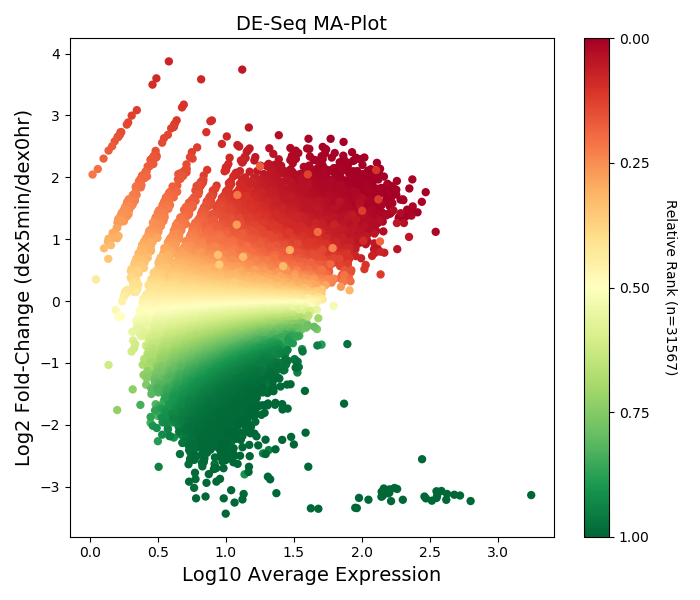

In [7]:
from IPython.display import Image
Image(filename = "Reddy_Timecourse/TF_ChIP/TFEA/NR3C1_dex0hr_dex5min/plots/DESEQ_MA_Plot.png")

## GR Enrichment Profile
Note this image generated by running TFEA on NR3C1 ChIP-Seq data from ENCODE.

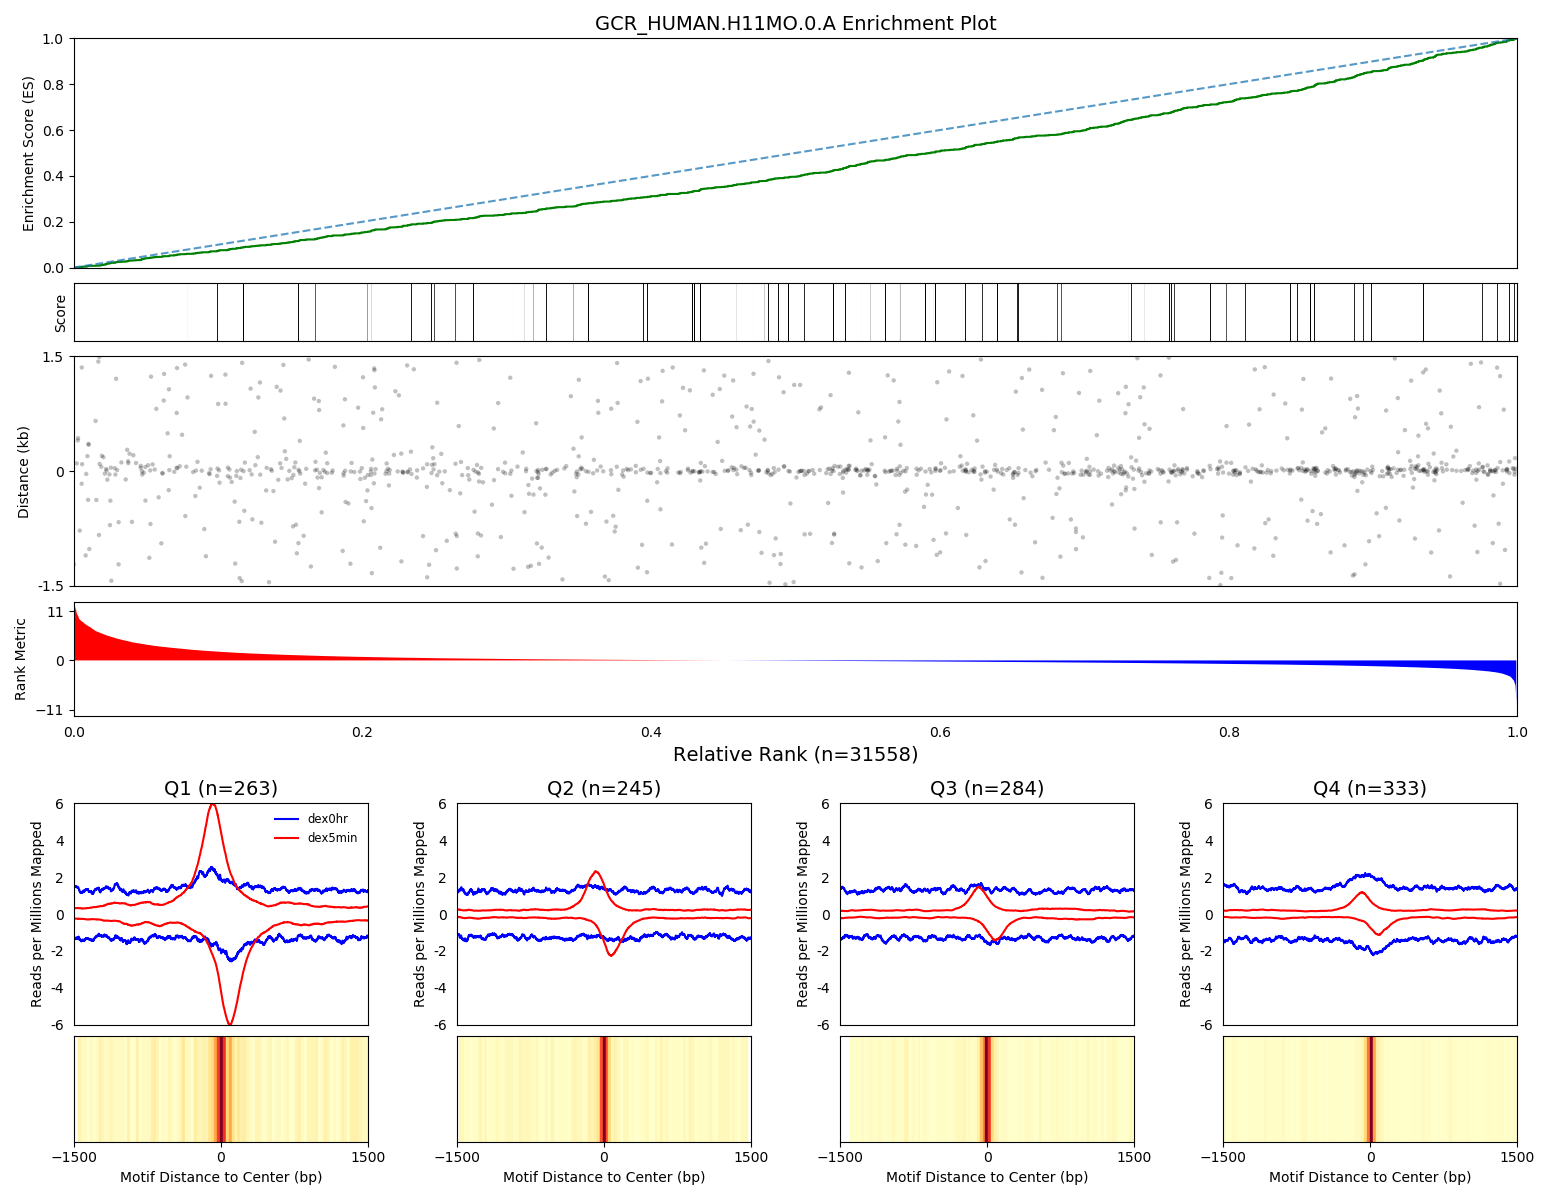

In [8]:
from IPython.display import Image
Image(filename = "Reddy_Timecourse/TF_ChIP/TFEA/NR3C1_dex0hr_dex5min/plots/GCR_HUMAN.H11MO.0.A_enrichment_plot.png")

## AME run on TF ChIP data

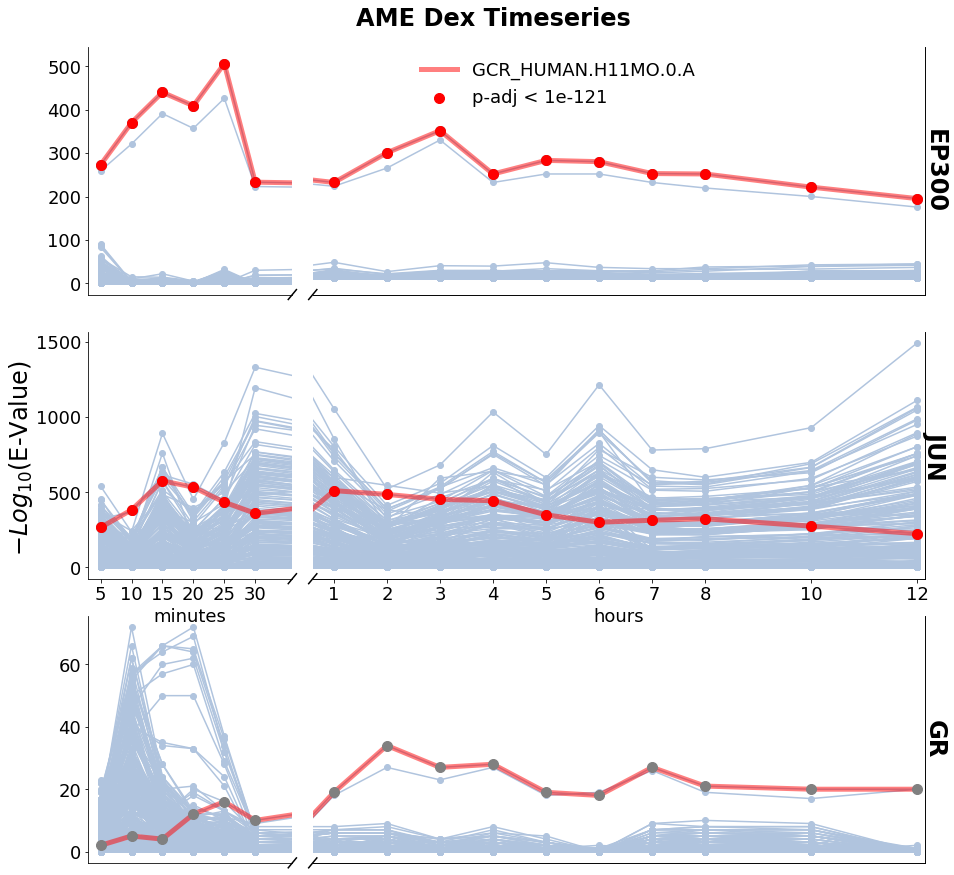

/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/Figures/AME_ChIP_timeseries_flat.pdf

In [5]:
def parse_results(parent_folder, results_file=None, assay=None, ame=False):
    '''
    Parameters
    ----------
    parent_folder : full path to a folder containing TFEA folders
    beds : dict of dicts with key1 = assay (ATAC, H3K27ac); key2 = treatment time (dex0hr); value = file
    results_file : str : name of tsv file to look for (ame.tsv, md_ame.tsv, mdd_ame.tsv)
    '''
    results = dict()
    for folder in Path(parent_folder).glob('*'):
        info = folder.name.split('_')
        exp = info[0]
        treatment = ''.join(info[1:]).replace('dex0hr', '').replace('hour', 'hr').replace('minute', 'min')
        treatment = 'dex' + treatment if 'dex' not in treatment else treatment
        if exp == assay:
            results[treatment] = list()
            if ame:
                result_file = folder / 'ame' / results_file
            else:
                result_file = folder / results_file
            if ame:
                result_list = [line.split('\t') for line in result_file.read_text().split('\n')[1:] if len(line.split('\t')) > 1 and '#' not in line.split('\t')[0]]
                result_list = [[line[2]] + [x for x in line[5:]] for line in result_list]
            else:
                result_list = [line.split('\t') for line in result_file.read_text().split('\n')[:-1] if '#' not in line[0]]
                result_list = [[line[0]] + [float(x) for x in line[1:]] for line in result_list]
            results[treatment].append(result_list)
    return results

def plot_time_results(results, motif=None, outer=None, x_index=2, ame=False, motif_i=0, events_i=3,label='', 
                      ticks=False, p_cut=1e-121, p_i=1):
    inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer, wspace=0.05, width_ratios=[1,3])
    ax_l = plt.Subplot(F, inner[0])
    ax_r = plt.Subplot(F, inner[1])
    
    sorted_keys = sorted([float(x.strip('dex').strip('min'))/60.0 if 'min' in x else float(x.strip('dex').strip('hr')) for x in results.keys()])
    xvals = sorted_keys
    sorted_keys = ['dex' + str(int(x)) + 'hr' if x.is_integer() else 'dex' + str(int(x*60.0)) + 'min' for x in sorted_keys]
    
    if ame:
        all_results = [[[-math.log(float(x2[x_index]),10) if 'e' not in x2[x_index] else float(x2[x_index].split('e')[-1].strip('-')) for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
    else:
        all_results = [[[x2[x_index] for x2 in sorted(x, key=lambda x: x[0])] for x in results[key]][0] for key in sorted_keys]
        
    ax_l.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, color='lightsteelblue', zorder=1)
    ax_r.scatter([[xvals[i] for j in range(len(all_results[i]))] for i in range(len(all_results))], all_results, color='lightsteelblue', zorder=1)
    all_results = np.array(all_results).T
    for motif_per_timepoint in all_results:
        ax_l.plot(xvals, motif_per_timepoint, color='lightsteelblue', zorder=2)
        ax_r.plot(xvals, motif_per_timepoint, color='lightsteelblue', zorder=2)

    if motif != None:
        list_flatten = lambda l: [item for sublist in l for item in sublist]
        if ame:
            motif_results = [[[-math.log(float(x2[x_index]),10) if 'e' not in x2[x_index] else float(x2[x_index].split('e')[-1].strip('-')) for x2 in x if x2[motif_i] == motif] for x in results[key]][0] for key in sorted_keys]
            significant_i = [[[k for x2 in x if x2[motif_i] == motif and float(x2[p_i]) < p_cut] for x in results[sorted_keys[k]]][0] for k in range(len(sorted_keys))]
            significant_i = list_flatten(significant_i)
        else:
            motif_results = [[[x2[x_index] for x2 in x if x2[motif_i] == motif] for x in results[key]][0] for key in sorted_keys]
            significant_i = [[[k for x2 in x if x2[motif_i] == motif and x2[p_i] < p_cut] for x in results[sorted_keys[k]]][0] for k in range(len(sorted_keys))]
            significant_i = list_flatten(significant_i)
            
        ax_l.plot(xvals, motif_results, c='r', alpha=0.5, linewidth=5, label=motif, zorder=3)
        ax_l.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, color='gray', zorder=4)
        if len(significant_i) > 0:
            ax_l.scatter([xvals[i] for i in significant_i], [motif_results[i] for i in significant_i], s=100, color='red', zorder=5)
            ax_r.scatter([xvals[i] for i in significant_i], [motif_results[i] for i in significant_i], s=100, color='red', zorder=5)
        ax_r.plot(xvals, motif_results, c='r', alpha=0.5, linewidth=5, label=motif, zorder=3)
        ax_r.scatter([[xvals[i] for j in range(len(motif_results[i]))] for i in range(len(motif_results))], motif_results, s=100, color='gray', zorder=4)
    if ticks:
        xticks = [5/60, 10/60, 15/60, 20/60, 25/60, 30/60, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12]
        xlabels = ['5', '10', '15', '20', '25', '30', '1','2', '3', '4', '5', '6',' 7', '8', '10', '12']
        ax_l.get_xaxis().set_ticks(xticks)
        ax_r.get_xaxis().set_ticks(xticks)
        ax_l.set_xticklabels(xlabels)
        ax_r.set_xticklabels(xlabels)
        ax_l.set_xlabel('minutes')
        ax_r.set_xlabel('hours')
    else:
        ax_l.get_xaxis().set_ticks([])
        ax_r.get_xaxis().set_ticks([])
        ax_l.set_xticklabels([])
        ax_r.set_xticklabels([])
    ax_l.set_xlim([0.05, 0.6])
    ax_r.set_xlim([0.6, 12.15])
    
    F.add_subplot(ax_r)
    F.add_subplot(ax_l)
    ax_r.spines['top'].set_visible(False)
    ax_l.spines['top'].set_visible(False)
    ax_l.spines['right'].set_visible(False)
    ax_r.spines['left'].set_visible(False)
    ax_r.get_yaxis().set_ticks([])
    #Draw cuts in plot
    d=0.02
    kwargs = dict(transform=ax_l.transAxes, color='k', clip_on=False)
    ax_l.plot((1-d, 1+d), (-d, +d), **kwargs)
    kwargs.update(transform=ax_r.transAxes)
    ax_r.plot((-d/3.0, +d/3.0), (-d, +d), **kwargs)
    
    axR = ax_r.twinx()
    axR.set_ylabel(label, rotation=270, labelpad=22, fontweight='bold', fontsize=24)
    axR.axes.get_yaxis().set_ticks([])
    axR.spines['top'].set_visible(False)
    axR.spines['left'].set_visible(False)
    
    return ax_l, ax_r

#========================================================================================================

F = plt.figure(figsize=(15,15))
outer = gridspec.GridSpec(3, 1, hspace=0.15)

#Plot TFEA results
F.text(0.5, 0.9, f'AME Dex Timeseries', ha='center', fontweight='bold', fontsize=24)
F.text(0.05, 0.5, '$-Log_{10}$(E-Value)', va='center', rotation=90, fontsize=24)
output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/TF_ChIP/TFEA'
results = parse_results(output_folder, results_file='ame.tsv', assay='EP300', ame=True)
ax_l, ax_r = plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[0], label='EP300', ame=True)
dummy = ax_r.scatter([0],[0], c='r', s=100, label='p-adj < 1e-121')
ax_r.legend(bbox_to_anchor=(0.55, 1, 0.1, 0.01), frameon=False)
dummy.remove()

results = parse_results(output_folder, results_file='ame.tsv', assay='NR3C1', ame=True)
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[2], label='GR', ticks=False, ame=True)

results = parse_results(output_folder, results_file='ame.tsv', assay='JUN', ame=True)
plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[1], label='JUN', ticks=True, ame=True)

# output_folder = '/scratch/Shares/dowell/for_jonathan'
# results = parse_results(output_folder, results_file='ame.tsv', assay='H3K4me1', ame=True)
# plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[3], label='H3K4me1', ame=True)

# results = parse_results(output_folder, results_file='ame.tsv', assay='H3K4me2', ame=True)
# plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[4], label='H3K4me2', ame=True)

# results = parse_results(output_folder, results_file='ame.tsv', assay='H3K4me3', ame=True)
# plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[5], label='H3K4me3', ame=True)

# results = parse_results(output_folder, results_file='ame.tsv', assay='H3K9me3', ame=True)
# plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[6], label='H3K9me3', ticks=False, ame=True)
# F.text(0.5, 0.06, 'Time after treatment with Dex', ha='center', fontweight='bold')

# output_folder = '/Users/joru1876/TFEA_Jupyter/Reddy_Timecourse/GCR/TFEA/'
# results = parse_results(output_folder, results_file='ame.tsv', assay='NR3C1', ame=True)
# plot_time_results(results, motif='GCR_HUMAN.H11MO.0.A', outer=outer[7], label='GCR', ticks=True, ame=True)

figname = os.path.join(figuredir, 'AME_ChIP_timeseries.pdf')
F.savefig(figname, bbox_inches='tight', format='pdf')
plt.show()
flattened = flatten(figname)
FileLink(str(Path(flattened).relative_to(Path.cwd())))
